In [1]:
%load_ext autotime

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import seaborn as sns
import pandas as pd 
import os

import opendiff.materials as mat
import opendiff.solver as solver
import opendiff.perturbation as pert
from opendiff import set_log_level, log_level

import grid_post_process as pp

solver.init_slepc()
set_log_level(log_level.warning)

time: 1.44 s (started: 2022-11-24 08:43:17 +01:00)


# Material creation

In [2]:
fuel1 = [[1.4360, 0.0095042, 0.0058708, 1, 0., 0.017754, 202 * 1.60218e-19 * 1e6, 2.4],
         [0.3635, 0.0750058, 0.0960670, 0, 0., 0., 202 * 1.60218e-19 * 1e6, 2.4]]
fuel2 = [[1.4366, 0.0096785, 0.0061908, 1, 0., 0.017621, 202 * 1.60218e-19 * 1e6, 2.4],
         [0.3636, 0.078436, 0.1035800, 0, 0., 0., 202 * 1.60218e-19 * 1e6, 2.4]]
refl = [[1.32, 0.0026562, 0, 1, 0., 0.023106, 202 * 1.60218e-19 * 1e6, 2.4],
        [0.2772, 0.071596, 0, 0, 0., 0., 202 * 1.60218e-19 * 1e6, 2.4]]
fuel3 = [[1.4389, 0.010363, 0.0074527, 1, 0., 0.017101, 202 * 1.60218e-19 * 1e6, 2.4],
         [0.3638, 0.091408, 0.1323600, 0, 0., 0., 202 * 1.60218e-19 * 1e6, 2.4]]
fuel4 = [[1.4381, 0.0100030, 0.0061908, 1, 0., 0.017290, 202 * 1.60218e-19 * 1e6, 2.4],
         [0.3665, 0.0848280, 0.103580, 0, 0., 0., 202 * 1.60218e-19 * 1e6, 2.4]]
fuel5 = [[1.4385, 0.0101320, 0.0064285, 1, 0., 0.017192, 202 * 1.60218e-19 * 1e6, 2.4],
         [0.3665, 0.087314, 0.109110, 0, 0., 0., 202 * 1.60218e-19 * 1e6, 2.4]]
fuel6 = [[1.4389, 0.010165, 0.0061908, 1, 0., 0.017125, 202 * 1.60218e-19 * 1e6, 2.4],
         [0.3679, 0.088024, 0.1035800, 0, 0., 0., 202 * 1.60218e-19 * 1e6, 2.4]]
fuel7 = [[1.4393, 0.010294, 0.0064285, 1, 0., 0.017027, 202 * 1.60218e-19 * 1e6, 2.4],
         [0.3680, 0.09051, 0.1091100, 0, 0., 0., 202 * 1.60218e-19 * 1e6, 2.4]]
void = [[1e10, 0., 0., 0, 0., 0., 202 * 1.60218e-19 * 1e6, 2.4],
        [1e10, 0., 0., 0, 0., 0., 202 * 1.60218e-19 * 1e6, 2.4]]
all_mat = [fuel1, fuel2, fuel3, fuel4, fuel5, fuel6, fuel7, refl, void]
mat_names = ["fuel1", "fuel2", "fuel3", "fuel4", "fuel5", "fuel6", "fuel7", "refl", "void"]
reac_names = ["D", "SIGA", "NU_SIGF", "CHI", "1", "2", "EFISS", "NU"]

mat_lib = mat.Materials(all_mat, mat_names, reac_names)

print(r"Material & Group (g) & $D_{g}$ & $\Sigma_{a,g}$ & $\nu \Sigma_{f,g}$ & $\Sigma_{1 \rigtarrow 2}$  \\ \hline")
for name, values_2g in zip(mat_names, all_mat):
    for i, values in enumerate(values_2g):
        print(f"{name} & {i+1} & {values[0]} & {values[1]} & {values[2]} & {values[5]} \\\ \hline")

Material & Group (g) & $D_{g}$ & $\Sigma_{a,g}$ & $\nu \Sigma_{f,g}$ & $\Sigma_{1 \rigtarrow 2}$  \\ \hline
fuel1 & 1 & 1.436 & 0.0095042 & 0.0058708 & 0.017754 \\ \hline
fuel1 & 2 & 0.3635 & 0.0750058 & 0.096067 & 0.0 \\ \hline
fuel2 & 1 & 1.4366 & 0.0096785 & 0.0061908 & 0.017621 \\ \hline
fuel2 & 2 & 0.3636 & 0.078436 & 0.10358 & 0.0 \\ \hline
fuel3 & 1 & 1.4389 & 0.010363 & 0.0074527 & 0.017101 \\ \hline
fuel3 & 2 & 0.3638 & 0.091408 & 0.13236 & 0.0 \\ \hline
fuel4 & 1 & 1.4381 & 0.010003 & 0.0061908 & 0.01729 \\ \hline
fuel4 & 2 & 0.3665 & 0.084828 & 0.10358 & 0.0 \\ \hline
fuel5 & 1 & 1.4385 & 0.010132 & 0.0064285 & 0.017192 \\ \hline
fuel5 & 2 & 0.3665 & 0.087314 & 0.10911 & 0.0 \\ \hline
fuel6 & 1 & 1.4389 & 0.010165 & 0.0061908 & 0.017125 \\ \hline
fuel6 & 2 & 0.3679 & 0.088024 & 0.10358 & 0.0 \\ \hline
fuel7 & 1 & 1.4393 & 0.010294 & 0.0064285 & 0.017027 \\ \hline
fuel7 & 2 & 0.368 & 0.09051 & 0.10911 & 0.0 \\ \hline
refl & 1 & 1.32 & 0.0026562 & 0 & 0.023106 \\ \hline
refl &

# Geometry and macrolib creation 

[Text(0, 0.0, ''),
 Text(0, 2.0, ''),
 Text(0, 4.0, ''),
 Text(0, 6.0, ''),
 Text(0, 8.0, ''),
 Text(0, 10.0, ''),
 Text(0, 12.0, ''),
 Text(0, 14.0, ''),
 Text(0, 16.0, ''),
 Text(0, 18.0, '')]

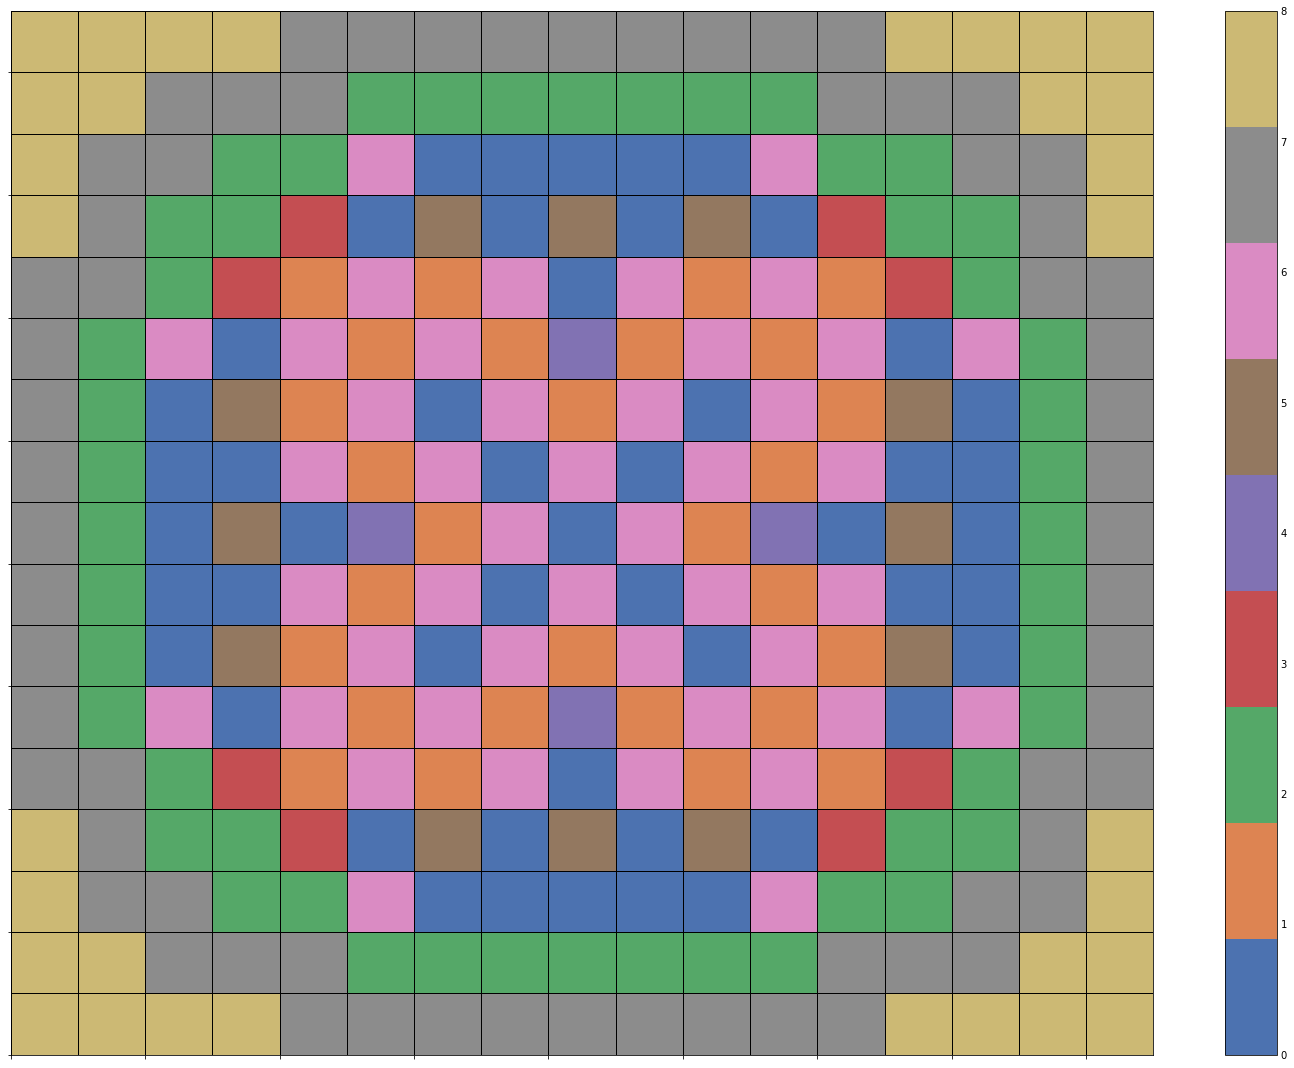

time: 2.24 s (started: 2022-11-24 08:43:19 +01:00)


In [3]:
x = [0, 17 * 23.1226]
y = [0, 17 * 23.1226]


pblm = np.array([["void",  "void",  "void",  "void",  "refl",  "refl",  "refl",  "refl",  "refl",  "refl",  "refl",  "refl",  "refl",  "void",  "void",  "void",  "void"], 
                 ["void",  "void",  "refl",  "refl",  "refl",  "fuel3", "fuel3", "fuel3", "fuel3", "fuel3", "fuel3", "fuel3", "refl",  "refl",  "refl",  "void",  "void"], 
                 ["void",  "refl",  "refl",  "fuel3", "fuel3", "fuel7", "fuel1", "fuel1", "fuel1", "fuel1", "fuel1", "fuel7", "fuel3", "fuel3", "refl",  "refl",  "void"], 
                 ["void",  "refl",  "fuel3", "fuel3", "fuel4", "fuel1", "fuel6", "fuel1", "fuel6", "fuel1", "fuel6", "fuel1", "fuel4", "fuel3", "fuel3", "refl",  "void"], 
                 ["refl",  "refl",  "fuel3", "fuel4", "fuel2", "fuel7", "fuel2", "fuel7", "fuel1", "fuel7", "fuel2", "fuel7", "fuel2", "fuel4", "fuel3", "refl",  "refl"],  
                 ["refl",  "fuel3", "fuel7", "fuel1", "fuel7", "fuel2", "fuel7", "fuel2", "fuel5", "fuel2", "fuel7", "fuel2", "fuel7", "fuel1", "fuel7", "fuel3", "refl"],  
                 ["refl",  "fuel3", "fuel1", "fuel6", "fuel2", "fuel7", "fuel1", "fuel7", "fuel2", "fuel7", "fuel1", "fuel7", "fuel2", "fuel6", "fuel1", "fuel3", "refl"],  
                 ["refl",  "fuel3", "fuel1", "fuel1", "fuel7", "fuel2", "fuel7", "fuel1", "fuel7", "fuel1", "fuel7", "fuel2", "fuel7", "fuel1", "fuel1", "fuel3", "refl"],  
                 ["refl",  "fuel3", "fuel1", "fuel6", "fuel1", "fuel5", "fuel2", "fuel7", "fuel1", "fuel7", "fuel2", "fuel5", "fuel1", "fuel6", "fuel1", "fuel3", "refl"],  
                 ["refl",  "fuel3", "fuel1", "fuel1", "fuel7", "fuel2", "fuel7", "fuel1", "fuel7", "fuel1", "fuel7", "fuel2", "fuel7", "fuel1", "fuel1", "fuel3", "refl"],  
                 ["refl",  "fuel3", "fuel1", "fuel6", "fuel2", "fuel7", "fuel1", "fuel7", "fuel2", "fuel7", "fuel1", "fuel7", "fuel2", "fuel6", "fuel1", "fuel3", "refl"],  
                 ["refl",  "fuel3", "fuel7", "fuel1", "fuel7", "fuel2", "fuel7", "fuel2", "fuel5", "fuel2", "fuel7", "fuel2", "fuel7", "fuel1", "fuel7", "fuel3", "refl"],  
                 ["refl",  "refl",  "fuel3", "fuel4", "fuel2", "fuel7", "fuel2", "fuel7", "fuel1", "fuel7", "fuel2", "fuel7", "fuel2", "fuel4", "fuel3", "refl",  "refl"],  
                 ["void",  "refl",  "fuel3", "fuel3", "fuel4", "fuel1", "fuel6", "fuel1", "fuel6", "fuel1", "fuel6", "fuel1", "fuel4", "fuel3", "fuel3", "refl",  "void"], 
                 ["void",  "refl",  "refl",  "fuel3", "fuel3", "fuel7", "fuel1", "fuel1", "fuel1", "fuel1", "fuel1", "fuel7", "fuel3", "fuel3", "refl",  "refl",  "void"], 
                 ["void",  "void",  "refl",  "refl",  "refl",  "fuel3", "fuel3", "fuel3", "fuel3", "fuel3", "fuel3", "fuel3", "refl",  "refl",  "refl",  "void",  "void"], 
                 ["void",  "void",  "void",  "void",  "refl",  "refl",  "refl",  "refl",  "refl",  "refl",  "refl",  "refl",  "refl",  "void",  "void",  "void",  "void"]])
# print(pblm)

#we mesh it 
nb_div_pmat_x = 20
nb_div_pmat_y = 20
shape = (pblm.shape[0]*nb_div_pmat_y, pblm.shape[1]*nb_div_pmat_x)
geom = np.empty(shape, dtype='U16')
for i, row in enumerate(pblm):
    for j, value in enumerate(row):
        geom[i*nb_div_pmat_x:(i+1)*nb_div_pmat_x, j *
             nb_div_pmat_x:(j+1)*nb_div_pmat_x] = value

geometry = np.array([geom])

x_mesh = np.linspace(x[0], x[1], geom.shape[1]+1)
x_mean = (x_mesh[:-1] + x_mesh[1:])/2.
dx = x_mesh[1:]-x_mesh[:-1]
y_mesh = np.linspace(y[0], y[1], geom.shape[0]+1)
y_mean = (y_mesh[:-1] + y_mesh[1:])/2.
dy = y_mesh[1:]-y_mesh[:-1]

# geometry_half = geometry[:, int(len(y_mesh)/2):, int(len(x_mesh)/2):]
# x_mesh_half = x_mesh[:int(len(x_mesh)/2)]
# y_mesh_half = y_mesh[:int(len(y_mesh)/2)]

macrolib = mat.Macrolib(mat_lib, geometry)

from matplotlib.colors import ListedColormap
import matplotlib
norm = matplotlib.colors.Normalize(vmin=-2., vmax=9)
# cmap = sns.color_palette("deep", as_cmap=True)
unique_mat, unique_inverse = np.unique(pblm, return_inverse=True)
fig, ax = plt.subplots(figsize=[6.4*4, 4.8*4])
cmap = ListedColormap(sns.color_palette("deep", as_cmap=True)[:len(unique_mat)])
quad = ax.pcolormesh(np.reshape(unique_inverse, pblm.shape), cmap=cmap, edgecolors="black")#, norm=norm)
# print(np.reshape(unique_inverse, pblm.shape)-0.5)
cbar = plt.colorbar(quad)
cbar.ax.tick_params(size=0)
# cbar.ax.set_yticklabels(unique_mat, labelsize=font_size)
ax.set_xticklabels([])
ax.set_yticklabels([])

# Solver creation

In [4]:
s = solver.SolverFullSlepc(x_mesh, y_mesh,
                       macrolib, 0., 0., 0., 0.)
s_star = solver.SolverFullSlepc(s)
s_star.makeAdjoint()

time: 3.32 s (started: 2022-11-24 08:43:22 +01:00)


# Solve the problem

In [5]:
path_s = "./biblis_2d.h5"
path_s_star = "./biblis_2d_star.h5"
if os.path.exists(path_s):
    s.load(path_s)
    s_star.load(path_s_star)
else:
    s.solve(tol=1e-15, nb_eigen_values=800, inner_max_iter=100, tol_inner=1e-4)
    s_star.solve(tol=1e-15, nb_eigen_values=800, inner_max_iter=100, tol_inner=1e-4)
    s.dump(path_s)
    s_star.dump(path_s_star)

nb_ev = 150
s.removeEigenVectors(list(range(nb_ev, 801)))
s_star.removeEigenVectors(list(range(nb_ev, 801)))

egval = s.getEigenValues()

time: 3.65 s (started: 2022-11-24 08:43:25 +01:00)


# Visualisation of the direct flux 

(2, 1, 340, 340)
(340, 340)
(2, 1, 340, 340)
(340, 340)


/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/grid_post_process.py:1183: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


(2, 1, 340, 340)
(340, 340)
(2, 1, 340, 340)
(340, 340)
(2, 1, 340, 340)
(340, 340)
(2, 1, 340, 340)
(340, 340)
(2, 1, 340, 340)
(340, 340)
(2, 1, 340, 340)
(340, 340)
(2, 1, 340, 340)
(340, 340)


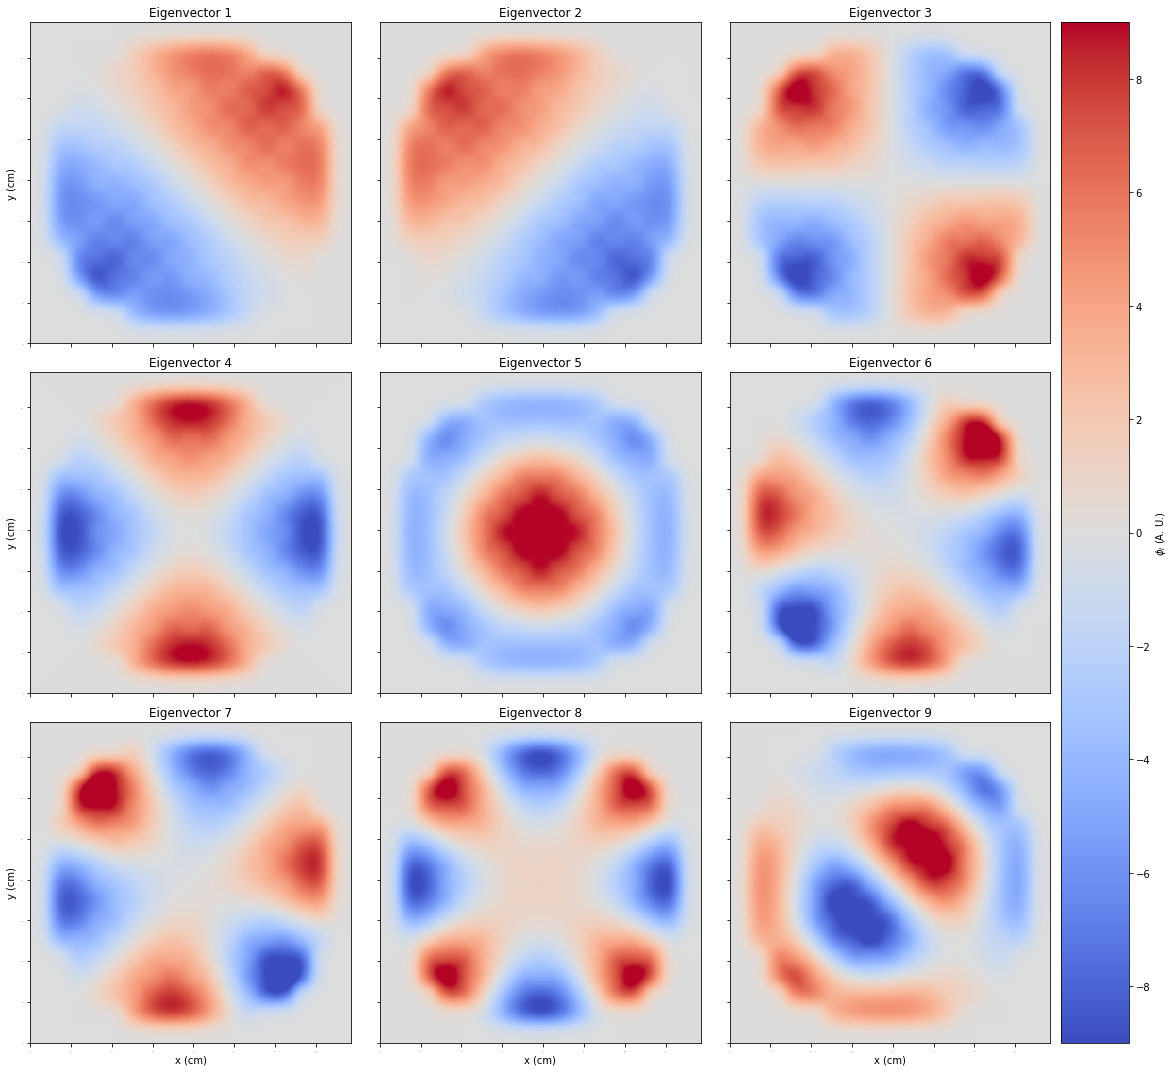

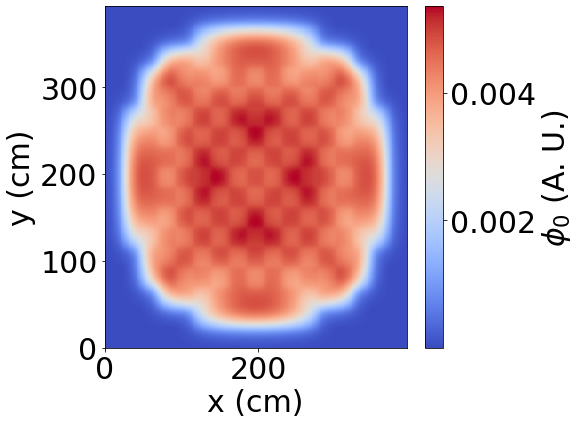

time: 3.25 s (started: 2022-11-24 08:48:19 +01:00)


In [13]:
# fig, axs = plt.subplots(3, 3, sharex=True, figsize=(12, 7))

fig = plt.figure(figsize=(20, 15))

axs = ImageGrid(fig, 111,
                 nrows_ncols=(3, 3),
                 axes_pad=0.4,
                 share_all=False,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15)
for i in range(9):
    k = i % 3
    j = i // 3
    phi = s.getEigenVector(i+1) * 1000
    pp.plot_map2d(phi[:, 0, :, :].sum(axis=0), [x_mesh, y_mesh], show=False, x_label=None, y_label=None, cbar=False,
                  show_stat_data=False, show_edge=False, show_xy=False, fig=fig, ax=axs[i],
                  vmin=-9, vmax=+9)
    if j == 2:
        axs[i].set_xlabel("x (cm)")
    if k == 0:
        axs[i].set_ylabel("y (cm)")
    axs[i].set_title(f"Eigenvector {i+1}")

cb = axs[0].cax.colorbar(axs[0].collections[0])
axs[0].cax.toggle_label(True)
cb.set_label(r"$\phi_i$ (A. U.)")

# fig.tight_layout()

pp.plot_map2d(s.getEigenVector(0)[:, 0, :, :].sum(axis=0), [x_mesh, y_mesh],
              show_stat_data=False, show_edge=False, label=r"$\phi_0$ (A. U.)", show_xy=True)

# Visualisation of the adjoint flux 

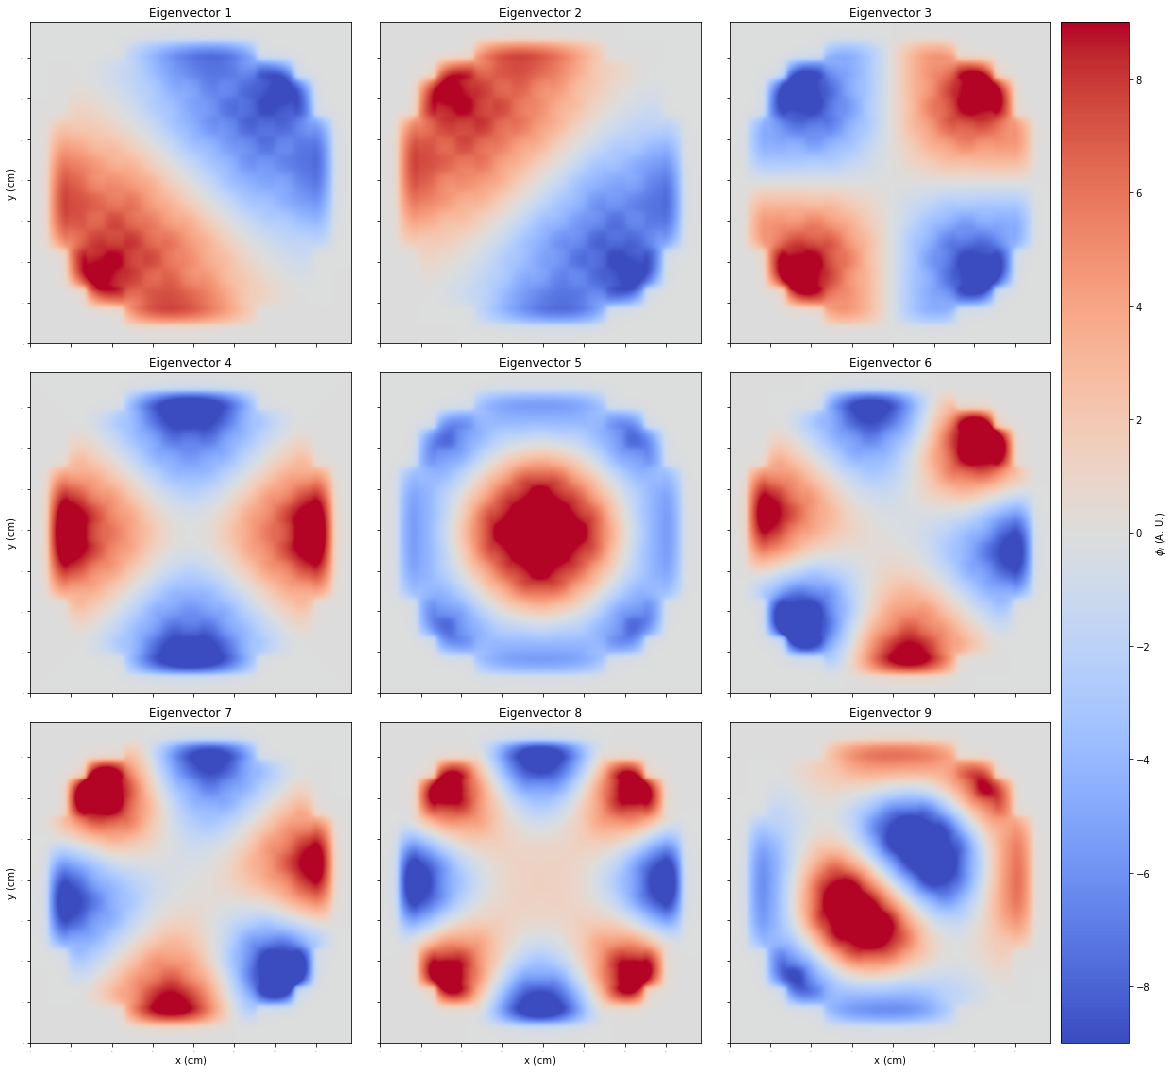

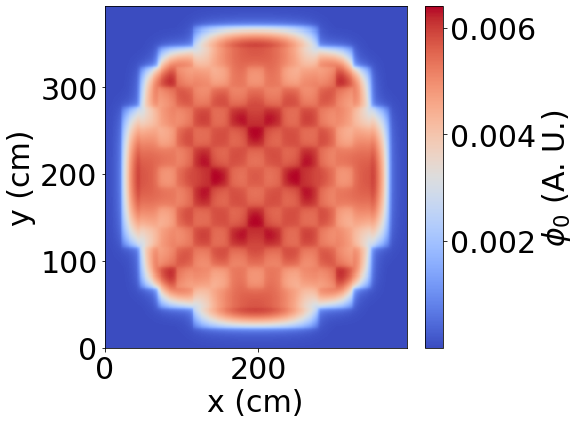

time: 2.86 s (started: 2022-11-24 08:49:18 +01:00)


In [14]:
# fig, axs = plt.subplots(3, 3, sharex=True, figsize=(12, 7))

fig = plt.figure(figsize=(20, 15))

axs = ImageGrid(fig, 111,
                 nrows_ncols=(3, 3),
                 axes_pad=0.4,
                 share_all=False,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15)
for i in range(9):
    k = i % 3
    j = i // 3
    phi = s_star.getEigenVector(i+1) * 1000
    pp.plot_map2d(phi[:, 0, :, :].sum(axis=0), [x_mesh, y_mesh], show=False, x_label=None, y_label=None, cbar=False,
                  show_stat_data=False, show_edge=False, show_xy=False, fig=fig, ax=axs[i],
                  vmin=-9, vmax=+9)
    if j == 2:
        axs[i].set_xlabel("x (cm)")
    if k == 0:
        axs[i].set_ylabel("y (cm)")
    axs[i].set_title(f"Eigenvector {i+1}")

cb = axs[0].cax.colorbar(axs[0].collections[0])
axs[0].cax.toggle_label(True)
cb.set_label(r"$\phi_i$ (A. U.)")

# fig.tight_layout()

pp.plot_map2d(s_star.getEigenVector(0)[:, 0, :, :].sum(axis=0), [x_mesh, y_mesh],
              show_stat_data=False, show_edge=False, label=r"$\phi_0$ (A. U.)", show_xy=True)

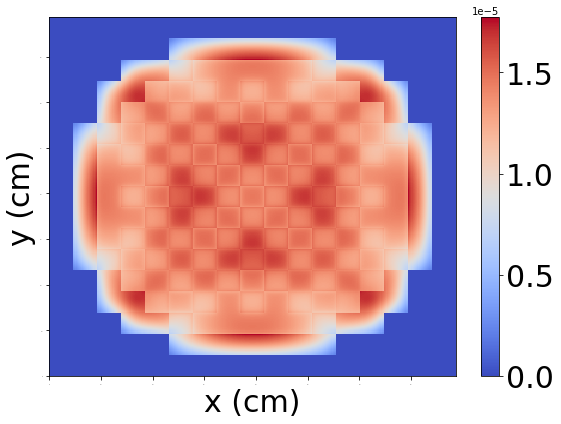

time: 1.06 s (started: 2022-11-24 08:49:24 +01:00)


In [15]:
power = s.normPower()
pp.plot_map2d(power.sum(axis=0), [x_mesh, y_mesh], show_stat_data=False, show_edge=False, show=True)

# Check biorthogonality and degenerated ev

In [16]:
print(nb_ev)
set_log_level(log_level.info)

print("norm")
s.normPhiStarMPhi(s_star)
print("degenerated")
pert.handleDegeneratedEigenvalues(s, s_star, 1e-6)
print("biorthogonality")
pert.checkBiOrthogonality(s, s_star, 1e-6, False, True)

print(len(s.getEigenValues()))
print(len(s_star.getEigenValues()))


150
[2022-11-24 08:49:32.439] [info] New orthogonalisation with a group of 2 eigenvectors from 1 to 2
113
113
time: 13min 56s (started: 2022-11-24 08:49:26 +01:00)
[2022-11-24 08:49:32.450] [info] New orthogonalisation with a group of 2 eigenvectors from 6 to 7
[2022-11-24 08:49:32.466] [info] New orthogonalisation with a group of 2 eigenvectors from 9 to 10
[2022-11-24 08:49:32.481] [info] New orthogonalisation with a group of 2 eigenvectors from 12 to 13
[2022-11-24 08:49:32.496] [info] New orthogonalisation with a group of 2 eigenvectors from 18 to 19
[2022-11-24 08:49:32.512] [info] New orthogonalisation with a group of 2 eigenvectors from 21 to 22
[2022-11-24 08:49:32.527] [info] New orthogonalisation with a group of 2 eigenvectors from 23 to 24
[2022-11-24 08:49:32.542] [info] New orthogonalisation with a group of 2 eigenvectors from 32 to 33
[2022-11-24 08:49:32.558] [info] New orthogonalisation with a group of 2 eigenvectors from 34 to 35
[2022-11-24 08:49:32.573] [info] New or

# First order modal expansion reconstruction  


## Removal op pertubation

In [17]:
mat_lib_pert = mat.Materials(mat_lib)
sigr = mat_lib_pert.getValue("fuel6", 1, "SIGR")*1.01
mat_lib_pert.setValue("fuel6", 1, "SIGR", sigr)

macrolib_pert = mat.Macrolib(mat_lib_pert, geometry)
s_pert_removal = solver.SolverFullSlepc(x_mesh, y_mesh,
                            macrolib_pert, 0., 0., 0., 0.)
s_pert_removal.solve(tol=1e-15, nb_eigen_values=1, inner_max_iter=10, tol_inner=1e-3)

s_recons_removal = solver.SolverFullSlepc(s_pert_removal)

[2022-11-24 09:03:37.752] [info] Number of converged eigenpairs: 1
[2022-11-24 09:03:37.766] [info] Eigen value 0 = 1.02469 +- 1.20e-06
time: 13.7 s (started: 2022-11-24 09:03:24 +01:00)


In [18]:
set_log_level(log_level.debug)
_, _, a_removal = pert.firstOrderPerturbation(
    s, s_star, s_recons_removal, "PhiStarMPhi")

time: 23.9 s (started: 2022-11-24 09:03:57 +01:00)


a0 =  0.9997055286635891


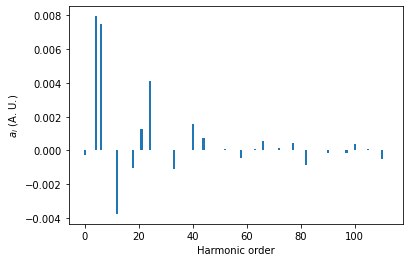

time: 266 ms (started: 2022-11-24 09:04:26 +01:00)


In [19]:
def plot_recons_coeff(a):
    print("a0 = ", a[0])
    a[0] -= 1
    fig, ax = plt.subplots()
    y_pos = np.arange(len(a))
    ax.bar(y_pos, a)
    ax.set_xlabel("Harmonic order")
    ax.set_ylabel("$a_i$ (A. U.)")
    plt.show()
    
plot_recons_coeff(a_removal)

vp recons =  1.0246728941230872
vp pert =  1.0246860822313557
vp ref =  1.0252767233369111
sens -56.22011544691699
sens recons -57.47616397384635
delta recons -1.25604852692936


/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/grid_post_process.py:1183: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


pert/ref - 1 (mean, std, min, max, relative entropy) :  0.05407740314848916 1.0516883323332915 -2.734540840744602 2.348165910121036 7.311654970716329e-05 1
recons/pert - 1 (mean, std, min, max, relative entropy) :  0.009912649768361297 0.10731538200115977 -0.34476993596890954 0.5429733176336444 7.109148985090383e-07 0.009723036731852097
power pert/ref - 1 (mean, std, min, max, relative entropy) :  -0.05240274025890453 1.174741913954512 -2.692529260229727 2.3451302507284675 7.223354653274195e-05 1
power recons/pert - 1 (mean, std, min, max, relative entropy) :  0.002335254408172719 0.11451551560745189 -0.3260446877650284 0.5159672070875883 6.157848308739761e-07 0.00852491481357424


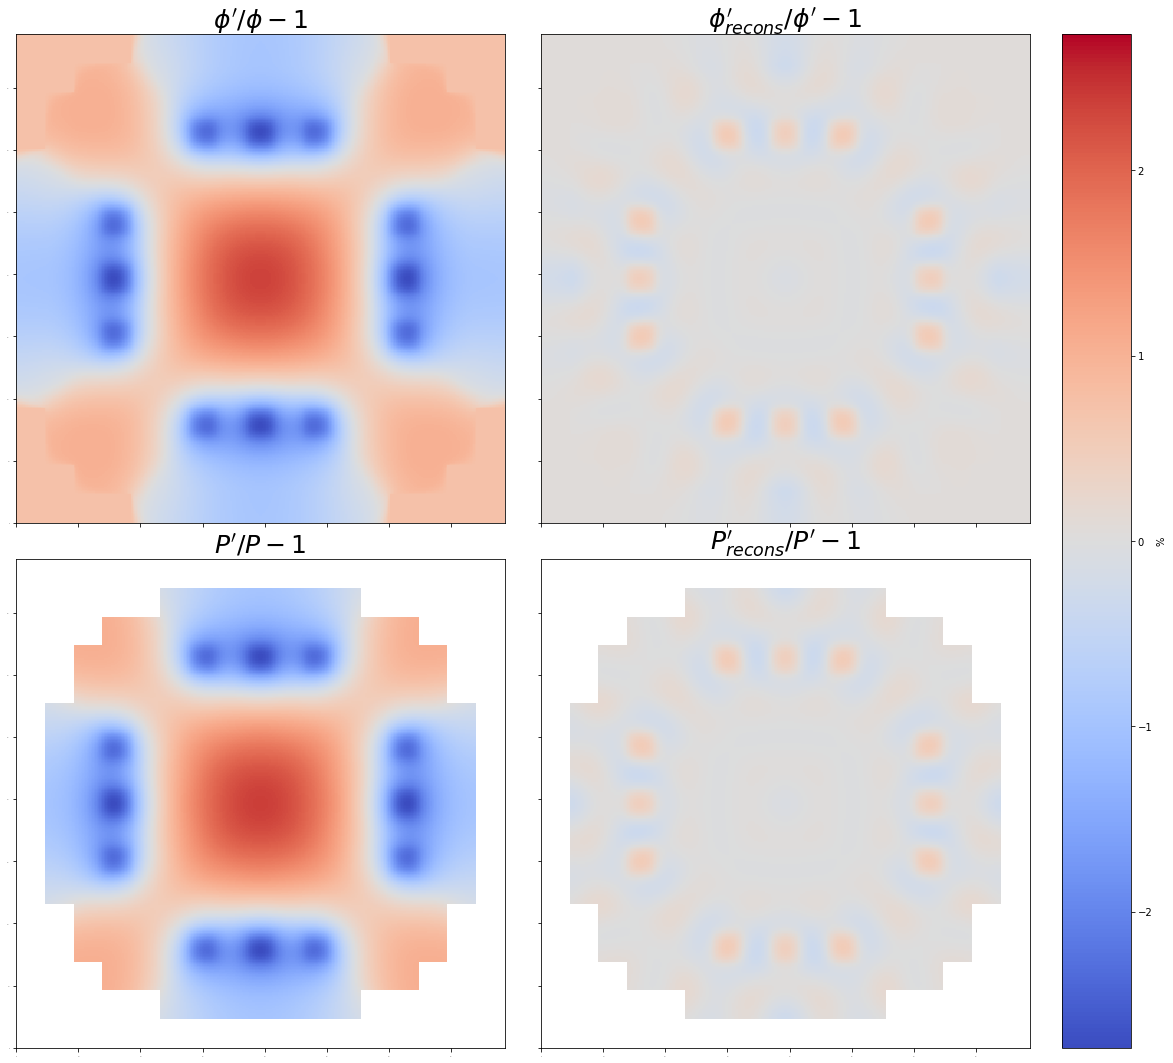

time: 2.04 s (started: 2022-11-24 09:04:50 +01:00)


In [20]:
def plot_delta(s, s_recons, s_pert):
    egval_recons = s_recons.getEigenValues()
    egval_pert = s_pert.getEigenValues()
    egval = s.getEigenValues()
    print("vp recons = ", egval_recons[0])
    print("vp pert = ", egval_pert[0])
    print("vp ref = ", egval[0])

    print("sens", 1e5*(egval_pert[0]-egval[0])/(egval[0]*egval_pert[0]))
    print("sens recons", 1e5*(egval_recons[0]-egval[0])/(egval[0]*egval_recons[0]))
    print("delta recons", 1e5*(egval_recons[0]-egval_pert[0])/(egval_pert[0]*egval_recons[0]))

    power_pert = s_pert.normPower().sum(axis=0)
    power = s.normPower().sum(axis=0)
    power_recons = s_recons.normPower().sum(axis=0)

    ev0 = s.getEigenVector(0).sum(axis=0)
    ev0_recons = s_recons.getEigenVector(0).sum(axis=0)
    ev0_pert = s_pert.getEigenVector(0).sum(axis=0)
    delta = 100*(ev0_pert-ev0)/ev0
    delta_recons = 100*(ev0_recons-ev0_pert)/ev0_pert

    ev0_pert_normed = ev0_pert / np.nansum(ev0_pert)
    ev0_recons_normed = ev0_recons / np.nansum(ev0_recons)
    ev0_normed = ev0 / np.nansum(ev0)

    ev0_pert_re = np.nansum(ev0_normed*np.log(ev0_normed/ev0_pert_normed))
    ev0_recons_re = np.nansum(ev0_pert_normed*np.log(ev0_pert_normed/ev0_recons_normed))

    delta_power = 100*(power_pert-power)/power
    delta_recons_power = 100*(power_recons-power_pert)/power_pert

    power_normed = power[~np.isnan(power)] / np.nansum(power)
    power_pert_normed = power_pert[~np.isnan(power_pert)] / np.nansum(power_pert)
    power_recons_normed = power_recons[~np.isnan(power_recons)] / np.nansum(power_recons)
    power_pert_re = np.nansum(power_normed*np.log(power_normed/power_pert_normed))
    power_recons_re = np.nansum(power_pert_normed*np.log(power_pert_normed/power_recons_normed))

    print("pert/ref - 1 (mean, std, min, max, relative entropy) : ", np.mean(delta), np.std(delta),
     np.min(delta), np.max(delta), ev0_pert_re, 1)
    print("recons/pert - 1 (mean, std, min, max, relative entropy) : ", np.mean(delta_recons), np.std(delta_recons),
     np.min(delta_recons), np.max(delta_recons), ev0_recons_re, ev0_recons_re/ev0_pert_re)


    print("power pert/ref - 1 (mean, std, min, max, relative entropy) : ", np.nanmean(delta_power), np.nanstd(delta_power),
     np.nanmin(delta_power), np.nanmax(delta_power), power_pert_re, 1)
    print("power recons/pert - 1 (mean, std, min, max, relative entropy) : ", np.nanmean(delta_recons_power), np.nanstd(delta_recons_power),
     np.nanmin(delta_recons_power), np.nanmax(delta_recons_power), power_recons_re, power_recons_re/power_pert_re)

    # sns.histplot([delta.flatten(), delta_recons.flatten()], log_scale=(False, True))
    # plt.show()
    # sns.histplot([delta.flatten(), delta_recons.flatten()])
    # plt.show()

    # sns.histplot([delta_power.flatten(), delta_recons_power.flatten()])
    # plt.show()


    # for i in range(9):
    #     k = i % 3
    #     j = i // 3
    #     phi = s.getEigenVector(i+1) * 1000
    #     pp.plot_map2d(phi[:, 0, :, :].sum(axis=0), [x_mesh, y_mesh], show=False, x_label=None, y_label=None, cbar=False,
    #                 show_stat_data=False, show_edge=False, show_xy=False, fig=fig, ax=axs[i],
    #                 vmin=-9, vmax=+9)
    #     if j == 2:
    #         axs[i].set_xlabel("x (cm)")
    #     if k == 0:
    #         axs[i].set_ylabel("y (cm)")
    #     axs[i].set_title(f"Eigenvector {i+1}")

    # cb = axs[0].cax.colorbar(axs[0].collections[0])
    # axs[0].cax.toggle_label(True)
    # cb.set_label(r"$\phi_i$ (A. U.)")


    fig = plt.figure(figsize=(20, 15))

    axs = ImageGrid(fig, 111,
                    nrows_ncols=(2, 2),
                    axes_pad=0.5,
                    share_all=False,
                    cbar_location="right",
                    cbar_mode="single",
                    cbar_size="7%",
                    cbar_pad=0.45)

    max_delta = np.max(np.abs(delta))
    pp.plot_map2d(delta.sum(axis=0),
                [x_mesh, y_mesh], show=False, x_label=None, y_label=None, cbar=False, show_stat_data=False, show_edge=False, show_xy=False, sym=True, stat_data_size=12,
                title="$\phi'/\phi - 1$", vmin=-max_delta, vmax=max_delta, stat_lang="en", fig=fig, ax=axs[0])

    pp.plot_map2d(delta_recons.sum(axis=0),
                [x_mesh, y_mesh], show=False, x_label=None, y_label=None, cbar=False, show_stat_data=False, show_edge=False, show_xy=False, sym=True, stat_data_size=12,
                title="$\phi_{recons}'/\phi' - 1$", vmin=-max_delta, vmax=max_delta, stat_lang="en", fig=fig, ax=axs[1])
    # pp.plot_map2d(100*(ev0_recons[:, :, 0]-ev0_pert[:, :, 0])/ev0_pert[:, :, 0], [x_mesh, y_mesh],
    #             show=True, x_label=None, y_label=None, cbar=True, show_stat_data=False, show_edge=False, show_xy=False, sym=True, stat_data_size=12,
    #             title="$\phi_0^{recons}'/\phi_0' - 1$", vmin=-max_delta, vmax=max_delta, stat_lang="en")
    # pp.plot_map2d(100*(ev0_recons[:, :, 1]-ev0_pert[:, :, 1])/ev0_pert[:, :, 1], [x_mesh, y_mesh],
    #             show=True, x_label=None, y_label=None, cbar=True, show_stat_data=False, show_edge=False, show_xy=False, sym=True, stat_data_size=12,
    #             title="$\phi_1^{recons}'/\phi_1' - 1$", vmin=-max_delta, vmax=max_delta, stat_lang="en")


    max_delta = np.nanmax(np.abs(delta_power))
    pp.plot_map2d(delta_power,
                [x_mesh, y_mesh], show=False, x_label=None, y_label=None, cbar=False, show_stat_data=False, show_edge=False, show_xy=False, sym=True, stat_data_size=12,
                title="$P'/P - 1$", vmin=-max_delta, vmax=max_delta, stat_lang="en", fig=fig, ax=axs[2])

    pp.plot_map2d(delta_recons_power,
                [x_mesh, y_mesh], show=False, x_label=None, y_label=None, cbar=False, show_stat_data=False, show_edge=False, show_xy=False, sym=True, stat_data_size=12,
                title="$P_{recons}'/P' - 1$", vmin=-max_delta, vmax=max_delta, stat_lang="en", fig=fig, ax=axs[3])

    cb = axs[0].cax.colorbar(axs[0].collections[0])
    axs[0].cax.toggle_label(True)
    cb.set_label(r"%")

    # axs[2].set_xlabel("x (cm)")
    # axs[3].set_xlabel("x (cm)")
    # axs[0].set_ylabel("y (cm)")
    # axs[2].set_ylabel("y (cm)")
        
    return (delta, delta_recons, ev0_recons_re/ev0_pert_re,
            delta_power, delta_recons_power, power_recons_re/power_pert_re)


(delta_sigr, delta_recons_sigr, re_sigr,
            delta_power_sigr, delta_recons_power_sigr, re_power_sigr) = plot_delta(s, s_recons_removal, s_pert_removal)

## Fuel xs perturbation 

In [21]:
mat_lib_pert = mat.Materials(mat_lib)
sigf = mat_lib_pert.getValue("fuel6", 2, "NU_SIGF")*1.01
mat_lib_pert.setValue("fuel6", 2, "NU_SIGF", sigf)

macrolib_pert = mat.Macrolib(mat_lib_pert, geometry)
s_pert_fiss = solver.SolverFullSlepc(x_mesh, y_mesh,
                            macrolib_pert, 0., 0., 0., 0.)
s_pert_fiss.solve(tol=1e-15, nb_eigen_values=1, inner_max_iter=10, tol_inner=1e-3)

s_recons_fiss = solver.SolverFullSlepc(s_pert_fiss)

[2022-11-24 09:05:16.936] [debug] Solver : krylovschur
[2022-11-24 09:05:16.936] [debug] Inner solver : 
[2022-11-24 09:05:16.936] [debug] Inner precond : 
[2022-11-24 09:05:16.936] [debug] Tolerance in outter iteration (eigen value): 1.00e-15
[2022-11-24 09:05:16.936] [debug] Tolerance in inner iteration : 1.00e-03
[2022-11-24 09:05:16.936] [debug] Max. outer iteration : 500
[2022-11-24 09:05:16.936] [debug] Max. inner iteration : 10
[2022-11-24 09:05:25.544] [info] Number of converged eigenpairs: 1
[2022-11-24 09:05:25.544] [debug] Number of outter iteration: 8
[2022-11-24 09:05:25.544] [debug] Slepc converged reason: tolerance
[2022-11-24 09:05:25.578] [info] Eigen value 0 = 1.02573 +- 1.19e-06
time: 13.7 s (started: 2022-11-24 09:05:11 +01:00)


a0 =  1.0


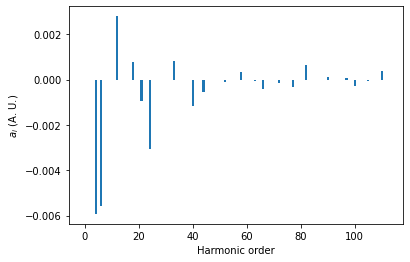

vp recons =  1.0257263757487916
vp pert =  1.0257334313709037
vp ref =  1.0252767233369111
sens 43.42732141757981
sens recons 42.75671257009594
delta recons -0.6706088474838615


/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


pert/ref - 1 (mean, std, min, max, relative entropy) :  -0.09307944883980795 0.7945835060194857 -1.7988801103430396 2.044816142996079 4.157550015527863e-05 1
recons/pert - 1 (mean, std, min, max, relative entropy) :  -0.000196427280450416 0.0788129866043075 -0.42335394000824766 0.21998117257381583 4.048039406566796e-07 0.009736598216372478
power pert/ref - 1 (mean, std, min, max, relative entropy) :  0.04105199033698139 0.983233359570169 -1.7966299374381145 2.7944003045461585 4.9640900489651845e-05 1
power recons/pert - 1 (mean, std, min, max, relative entropy) :  -0.0008149630835588404 0.08544840569387223 -0.4037888221489013 0.21123797151442605 3.5064183235703984e-07 0.007063567117001327


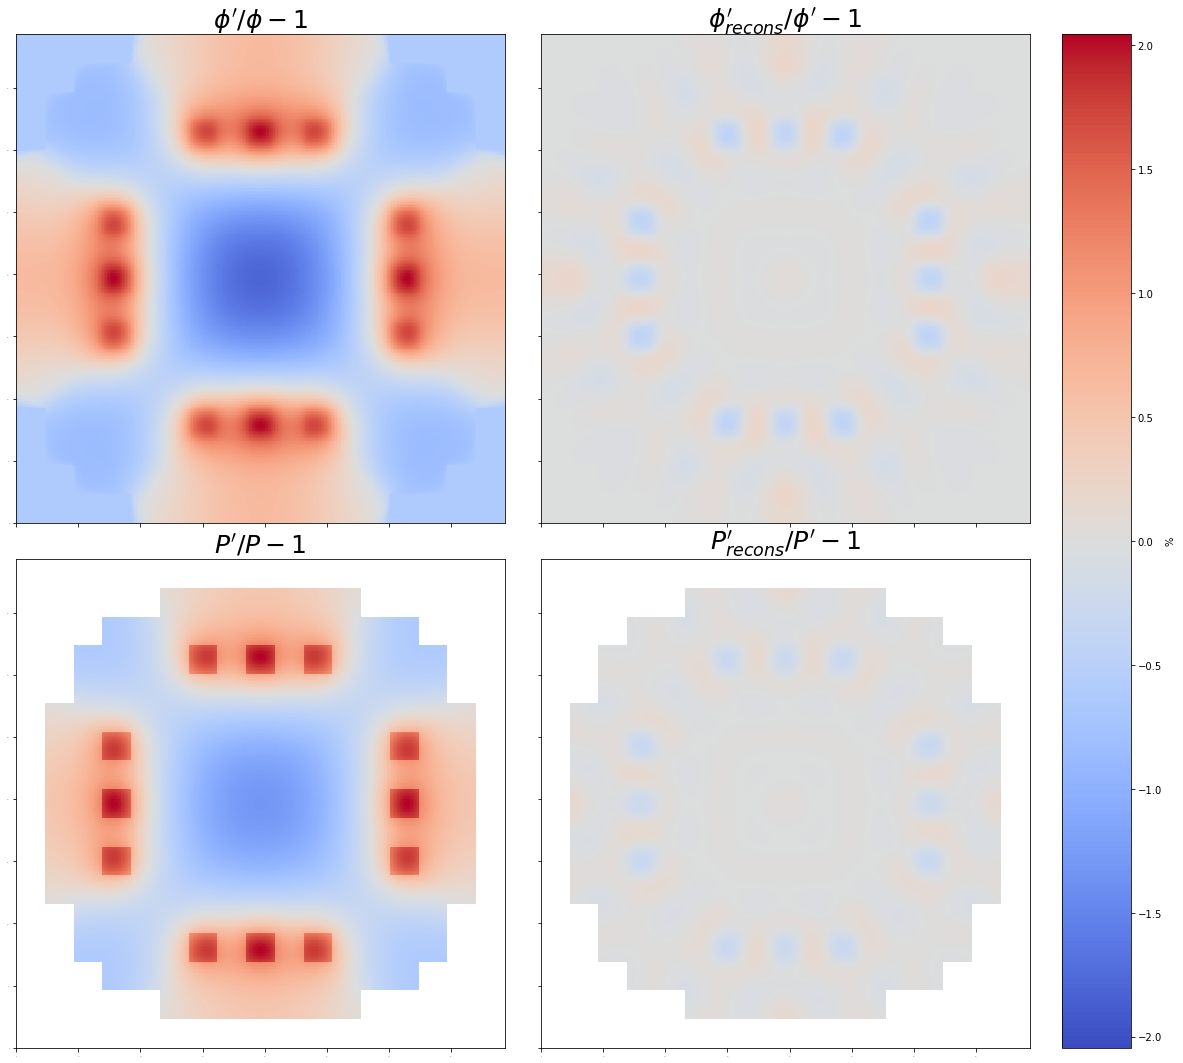

time: 32.3 s (started: 2022-11-24 09:05:30 +01:00)


In [22]:
set_log_level(log_level.debug)
egvec_recons, egval_recons, a = pert.firstOrderPerturbation(
    s, s_star, s_recons_fiss, "PhiStarMPhi")

plot_recons_coeff(a)
(delta_sigf, delta_recons_sigf, re_sigf,
            delta_power_sigf, delta_recons_power_sigf, re_power_sigf) = plot_delta(s, s_recons_fiss, s_pert_fiss)

## Diff fuel1 pertubation

[2022-11-24 09:06:15.673] [debug] Solver : krylovschur
[2022-11-24 09:06:15.673] [debug] Inner solver : 
[2022-11-24 09:06:15.673] [debug] Inner precond : 
[2022-11-24 09:06:15.673] [debug] Tolerance in outter iteration (eigen value): 1.00e-15
[2022-11-24 09:06:15.673] [debug] Tolerance in inner iteration : 1.00e-03
[2022-11-24 09:06:15.673] [debug] Max. outer iteration : 500
[2022-11-24 09:06:15.673] [debug] Max. inner iteration : 10
[2022-11-24 09:06:22.469] [info] Number of converged eigenpairs: 1
[2022-11-24 09:06:22.469] [debug] Number of outter iteration: 8
[2022-11-24 09:06:22.469] [debug] Slepc converged reason: tolerance
[2022-11-24 09:06:22.483] [info] Eigen value 0 = 1.02527 +- 1.20e-06
a0 =  0.9999981407447811


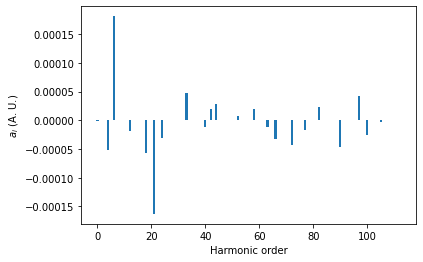

vp recons =  1.0252729108347138
vp pert =  1.0252729316570228
vp ref =  1.0252767233369111
sens -0.3607040972824762
sens recons -0.3626849396312191
delta recons -0.001980842348742829


/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


pert/ref - 1 (mean, std, min, max, relative entropy) :  0.010672079799436155 0.03141862269788963 -0.06854592745323701 0.08159361399046858 4.1530177028155774e-08 1
recons/pert - 1 (mean, std, min, max, relative entropy) :  -0.0017115669740233735 0.00596160291103002 -0.02042002664074808 0.017023184788040106 1.5708728817487843e-09 0.03782485397747754
power pert/ref - 1 (mean, std, min, max, relative entropy) :  0.0032176157523438604 0.03030147594107781 -0.06796323928539105 0.07588768489125453 4.153038772465294e-08 1
power recons/pert - 1 (mean, std, min, max, relative entropy) :  -0.00018573130141933742 0.006302679613852278 -0.028153621917592582 0.016265590770853988 1.8387367237407532e-09 0.04427448970454125


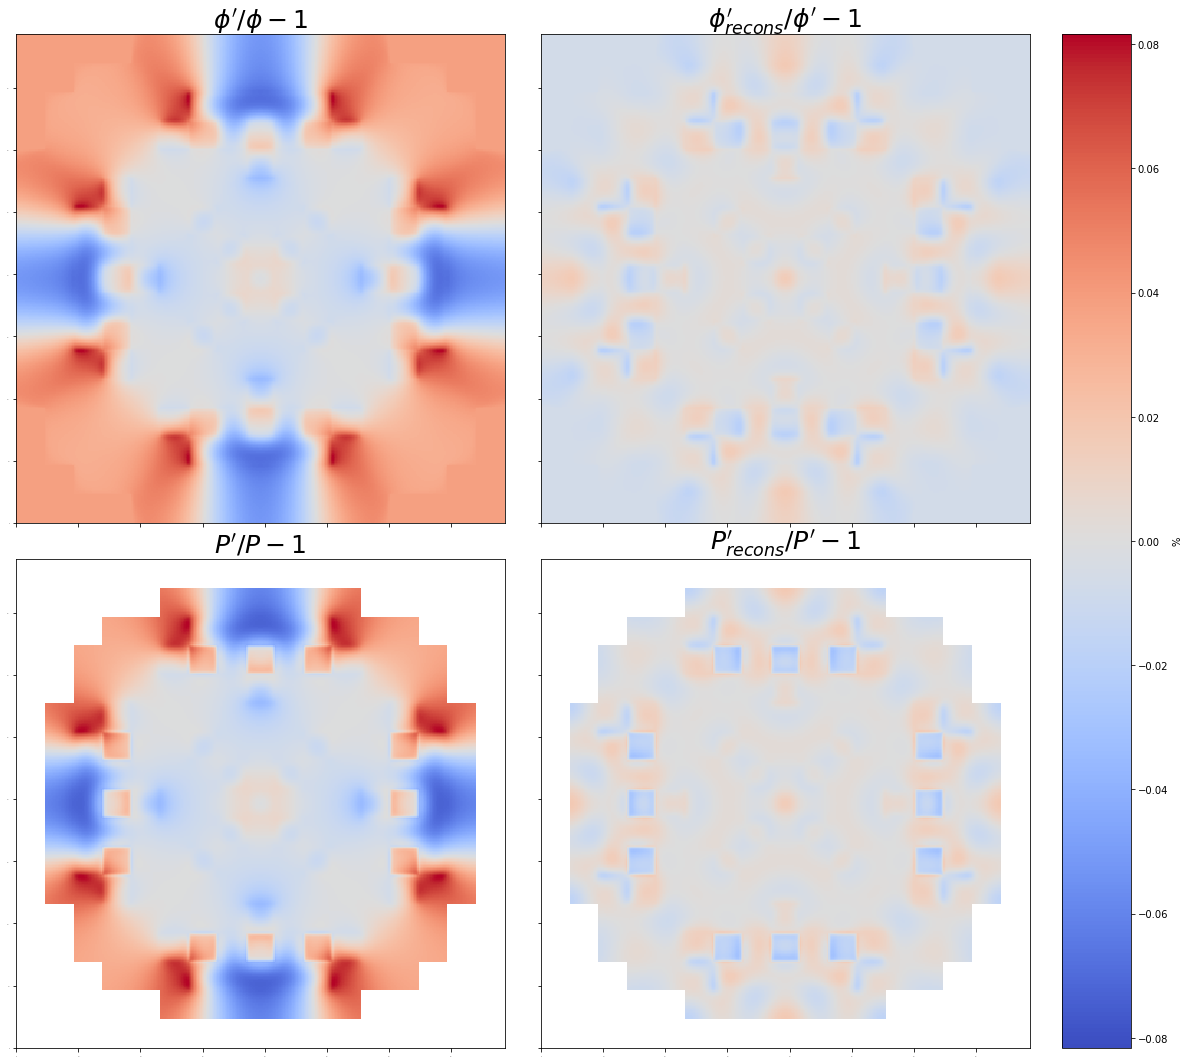

time: 44 s (started: 2022-11-24 09:06:09 +01:00)


In [23]:
mat_lib_pert = mat.Materials(mat_lib)
D = mat_lib_pert.getValue("fuel6", 2, "D")*1.01
mat_lib_pert.setValue("fuel6", 2, "D", D)
D = mat_lib_pert.getValue("fuel1", 1, "D")*1.01
mat_lib_pert.setValue("fuel1", 1, "D", D)

macrolib_pert = mat.Macrolib(mat_lib_pert, geometry)
s_pert_D = solver.SolverFullSlepc(x_mesh, y_mesh,
                            macrolib_pert, 0., 0., 0., 0.)
s_pert_D.solve(tol=1e-15, nb_eigen_values=1, inner_max_iter=10, tol_inner=1e-3)

s_recons_D = solver.SolverFullSlepc(s_pert_D)

set_log_level(log_level.debug)
egvec_recons, egval_recons, a = pert.firstOrderPerturbation(
    s, s_star, s_recons_D, "PhiStarMPhi")

plot_recons_coeff(a)
(delta_D, delta_recons_D, re_D,
            delta_power_D, delta_recons_power_D, re_power_D) = plot_delta(s, s_recons_D, s_pert_D)

## Scattering fuel1 pertubation

[2022-11-24 09:07:05.723] [debug] Solver : krylovschur
[2022-11-24 09:07:05.723] [debug] Inner solver : 
[2022-11-24 09:07:05.723] [debug] Inner precond : 
[2022-11-24 09:07:05.723] [debug] Tolerance in outter iteration (eigen value): 1.00e-15
[2022-11-24 09:07:05.723] [debug] Tolerance in inner iteration : 1.00e-03
[2022-11-24 09:07:05.723] [debug] Max. outer iteration : 500
[2022-11-24 09:07:05.723] [debug] Max. inner iteration : 10
[2022-11-24 09:07:12.185] [info] Number of converged eigenpairs: 1
[2022-11-24 09:07:12.185] [debug] Number of outter iteration: 8
[2022-11-24 09:07:12.185] [debug] Slepc converged reason: tolerance
[2022-11-24 09:07:12.195] [info] Eigen value 0 = 1.02534 +- 1.20e-06
a0 =  1.000031045376998


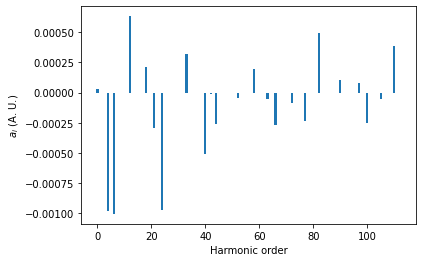

vp recons =  1.0253403835417176
vp pert =  1.0253404738838783
vp ref =  1.0252767233369111
sens 6.064216763534053
sens recons 6.055623575608725
delta recons -0.008593187925327287


/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


pert/ref - 1 (mean, std, min, max, relative entropy) :  -0.042964096963726606 0.12108062663076606 -0.2883899945444689 0.3515579713184744 9.771248639338735e-07 1
recons/pert - 1 (mean, std, min, max, relative entropy) :  0.02528978257049648 0.0779654317202424 -0.1279991236698715 0.28908477811555994 3.683405510584717e-07 0.3769636457469155
power pert/ref - 1 (mean, std, min, max, relative entropy) :  0.007710327390324868 0.23301166218766273 -0.28807096101886026 0.9452981307149274 2.6515187367536875e-06 1
power recons/pert - 1 (mean, std, min, max, relative entropy) :  -0.001302922473688881 0.1179641684586791 -0.4786401930548535 0.2754646980084564 6.67341886409787e-07 0.2516828854194062


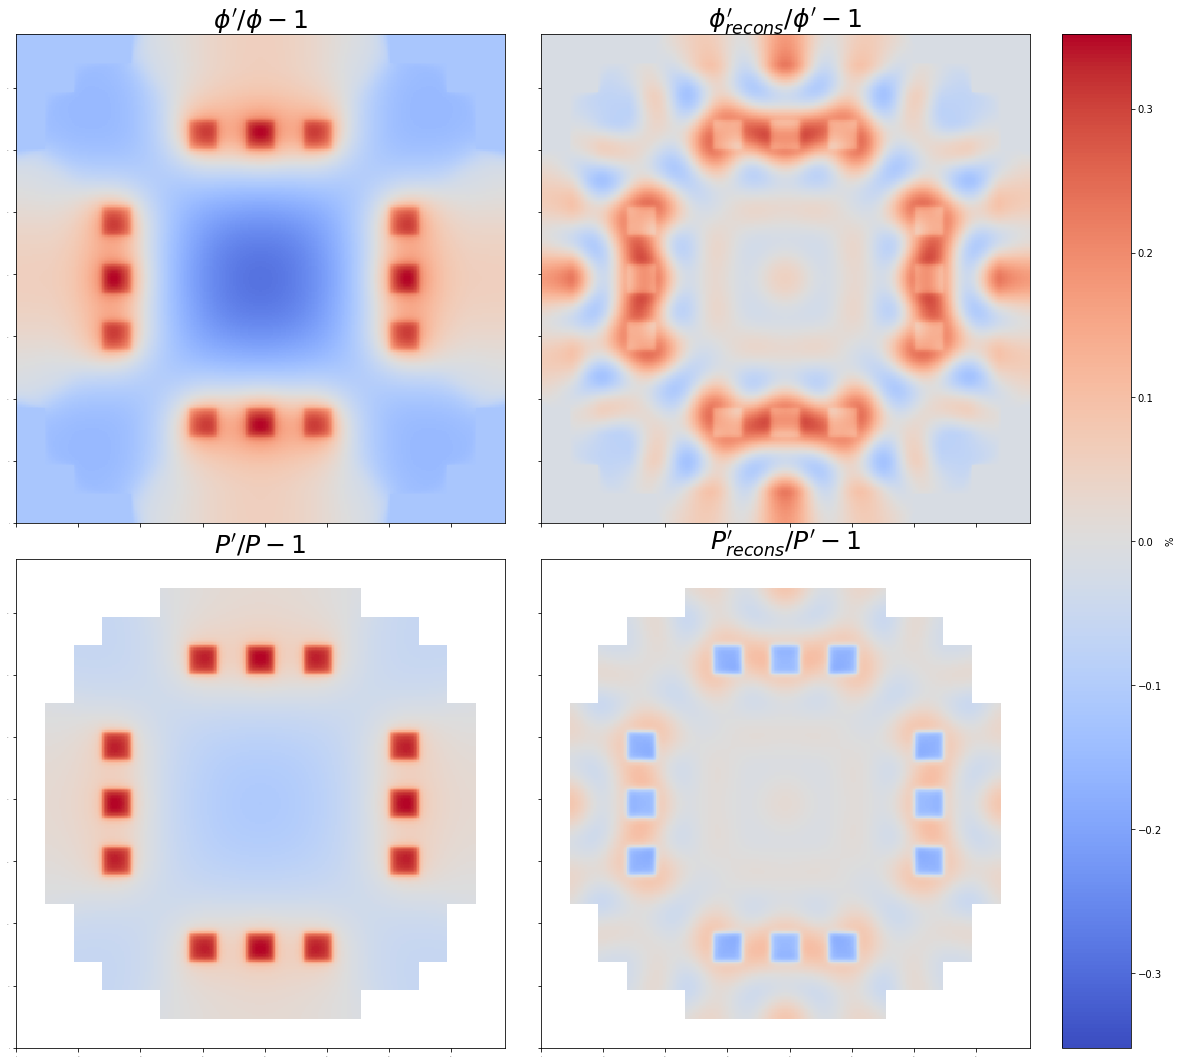

time: 45.9 s (started: 2022-11-24 09:06:59 +01:00)


In [24]:
mat_lib_pert = mat.Materials(mat_lib)
scat = mat_lib_pert.getValue("fuel6", 1, "2")*1.01
mat_lib_pert.setValue("fuel6", 1, "2", scat)

macrolib_pert = mat.Macrolib(mat_lib_pert, geometry)
s_pert_scatt = solver.SolverFullSlepc(x_mesh, y_mesh,
                            macrolib_pert, 0., 0., 0., 0.)
s_pert_scatt.solve(tol=1e-15, nb_eigen_values=1, inner_max_iter=10, tol_inner=1e-3)

s_recons_scatt = solver.SolverFullSlepc(s_pert_scatt)

set_log_level(log_level.debug)
egvec_recons, egval_recons, a = pert.firstOrderPerturbation(
    s, s_star, s_recons_scatt, "PhiStarMPhi")

plot_recons_coeff(a)
(delta_scatt, delta_recons_scatt, re_scatt,
            delta_power_scatt, delta_recons_power_scatt, re_power_scatt) = plot_delta(s, s_recons_scatt, s_pert_scatt)

## Refl xs perturbation 

In [25]:
mat_lib_pert = mat.Materials(mat_lib)
sigf = mat_lib_pert.getValue("refl", 1, "SIGA")*1.01
mat_lib_pert.setValue("refl", 1, "SIGA", sigf)

macrolib_pert = mat.Macrolib(mat_lib_pert, geometry)
s_pert_refl = solver.SolverFullSlepc(x_mesh, y_mesh,
                            macrolib_pert, 0., 0., 0., 0.)
s_pert_refl.solve(tol=1e-15, nb_eigen_values=1, inner_max_iter=10, tol_inner=1e-3)

s_recons_refl = solver.SolverFullSlepc(s_pert_refl)

[2022-11-24 09:08:08.736] [debug] Solver : krylovschur
[2022-11-24 09:08:08.736] [debug] Inner solver : 
[2022-11-24 09:08:08.736] [debug] Inner precond : 
[2022-11-24 09:08:08.736] [debug] Tolerance in outter iteration (eigen value): 1.00e-15
[2022-11-24 09:08:08.736] [debug] Tolerance in inner iteration : 1.00e-03
[2022-11-24 09:08:08.736] [debug] Max. outer iteration : 500
[2022-11-24 09:08:08.736] [debug] Max. inner iteration : 10
[2022-11-24 09:08:14.978] [info] Number of converged eigenpairs: 1
[2022-11-24 09:08:14.979] [debug] Number of outter iteration: 8
[2022-11-24 09:08:14.979] [debug] Slepc converged reason: tolerance
[2022-11-24 09:08:14.992] [info] Eigen value 0 = 1.02527 +- 1.18e-06
time: 11.3 s (started: 2022-11-24 09:08:03 +01:00)


a0 =  0.9999973481903416


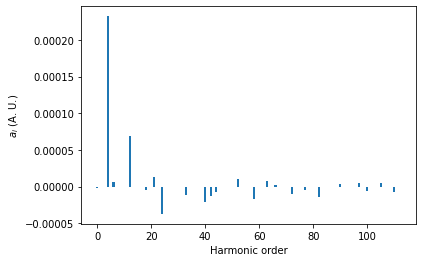

vp recons =  1.0252712856594761
vp pert =  1.0252712910162936
vp ref =  1.0252767233369111
sens -0.5167797645814339
sens recons -0.5172893643877486
delta recons -0.0005095998063146909


/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


pert/ref - 1 (mean, std, min, max, relative entropy) :  -0.06418625762383022 0.09290497669412648 -0.2689312453887559 0.03953294008389283 5.445665967130403e-08 1
recons/pert - 1 (mean, std, min, max, relative entropy) :  0.043274748234159895 0.06710485294584259 -0.007395020558710038 0.20877067627728702 8.441877643888474e-09 0.15502011498397003
power pert/ref - 1 (mean, std, min, max, relative entropy) :  -0.004406430602864367 0.028963555924812413 -0.10672017260765676 0.039505662397421676 3.524587317252448e-08 1
power recons/pert - 1 (mean, std, min, max, relative entropy) :  0.0004254247421407454 0.003930951276402849 -0.006911438731038568 0.044039076116188514 3.8968681698952706e-10 0.011056239551281793


(array([[[-0.22760992, -0.22760992, -0.22760992, ..., -0.2276292 ,
          -0.2276292 , -0.2276292 ],
         [-0.22760992, -0.22760992, -0.22760992, ..., -0.2276292 ,
          -0.2276292 , -0.2276292 ],
         [-0.22760992, -0.22760992, -0.22760992, ..., -0.2276292 ,
          -0.2276292 , -0.2276292 ],
         ...,
         [-0.22756183, -0.22756183, -0.22756183, ..., -0.22767377,
          -0.22767377, -0.22767377],
         [-0.22756183, -0.22756183, -0.22756183, ..., -0.22767377,
          -0.22767377, -0.22767377],
         [-0.22756183, -0.22756183, -0.22756183, ..., -0.22767377,
          -0.22767377, -0.22767377]]]),
 array([[[0.17034453, 0.17034453, 0.17034453, ..., 0.17036394,
          0.17036394, 0.17036394],
         [0.17034453, 0.17034453, 0.17034453, ..., 0.17036394,
          0.17036394, 0.17036394],
         [0.17034453, 0.17034453, 0.17034453, ..., 0.17036394,
          0.17036394, 0.17036394],
         ...,
         [0.1702963 , 0.1702963 , 0.1702963 , ..., 

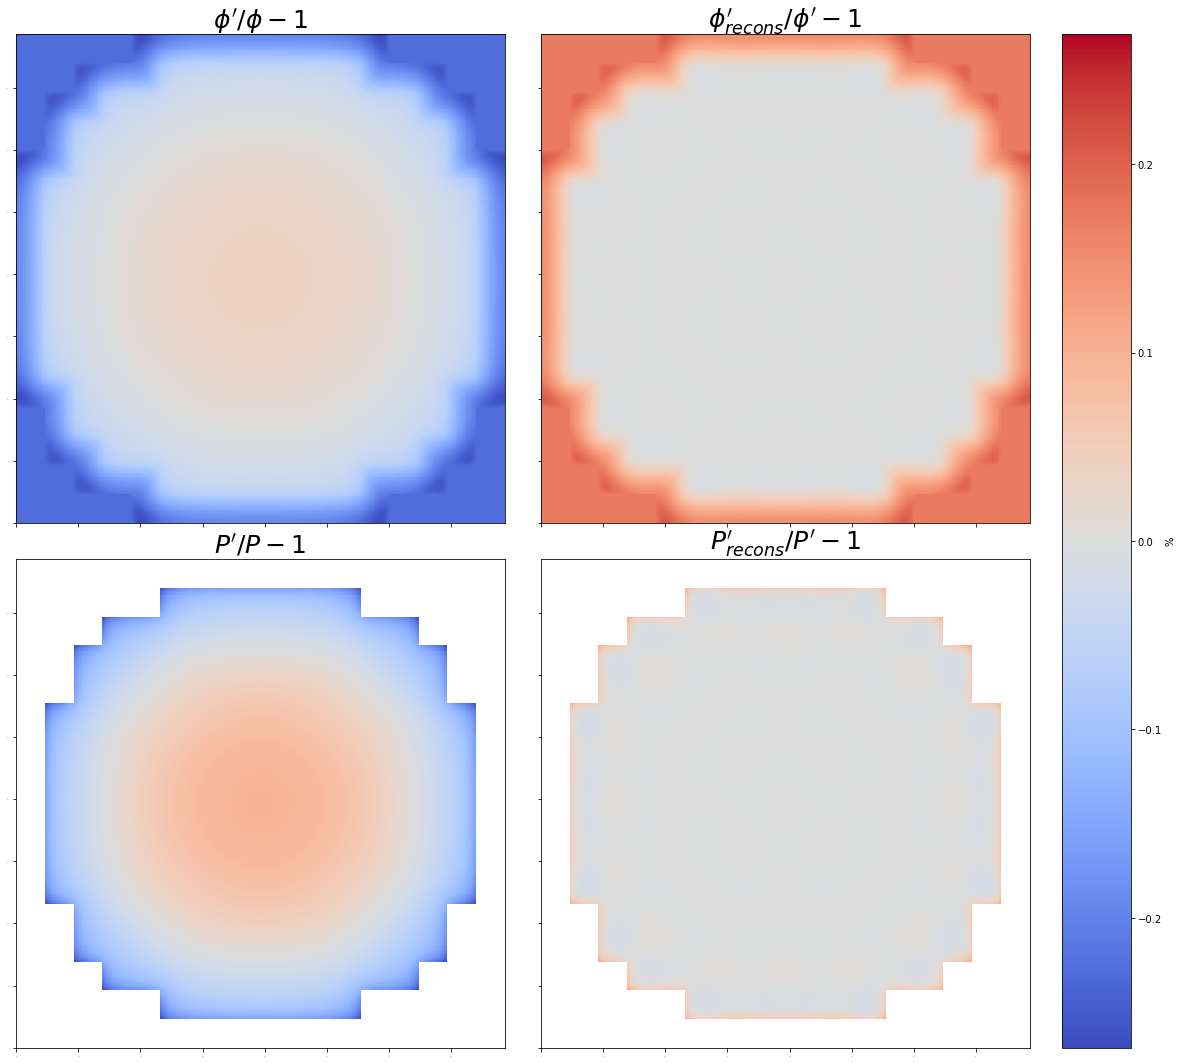

time: 33.5 s (started: 2022-11-24 09:08:24 +01:00)


In [26]:
set_log_level(log_level.debug)
_, _, a = pert.firstOrderPerturbation(
    s, s_star, s_recons_refl, "PhiStarMPhi")

plot_recons_coeff(a)
plot_delta(s, s_recons_refl, s_pert_refl)

In [27]:
mat_lib_pert = mat.Materials(mat_lib)
sigf = mat_lib_pert.getValue("refl", 1, "2")*1.01
mat_lib_pert.setValue("refl", 1, "2", sigf)

macrolib_pert = mat.Macrolib(mat_lib_pert, geometry)
s_pert_refl2 = solver.SolverFullSlepc(x_mesh, y_mesh,
                            macrolib_pert, 0., 0., 0., 0.)
s_pert_refl2.solve(tol=1e-15, nb_eigen_values=1, inner_max_iter=10, tol_inner=1e-3)

s_recons_refl2 = solver.SolverFullSlepc(s_pert_refl2)

[2022-11-24 09:09:17.442] [debug] Solver : krylovschur
[2022-11-24 09:09:17.442] [debug] Inner solver : 
[2022-11-24 09:09:17.442] [debug] Inner precond : 
[2022-11-24 09:09:17.442] [debug] Tolerance in outter iteration (eigen value): 1.00e-15
[2022-11-24 09:09:17.442] [debug] Tolerance in inner iteration : 1.00e-03
[2022-11-24 09:09:17.442] [debug] Max. outer iteration : 500
[2022-11-24 09:09:17.442] [debug] Max. inner iteration : 10
[2022-11-24 09:09:23.830] [info] Number of converged eigenpairs: 1
[2022-11-24 09:09:23.830] [debug] Number of outter iteration: 8
[2022-11-24 09:09:23.830] [debug] Slepc converged reason: tolerance
[2022-11-24 09:09:23.837] [info] Eigen value 0 = 1.02525 +- 1.19e-06
time: 11.5 s (started: 2022-11-24 09:09:12 +01:00)


a0 =  0.9999861683365859


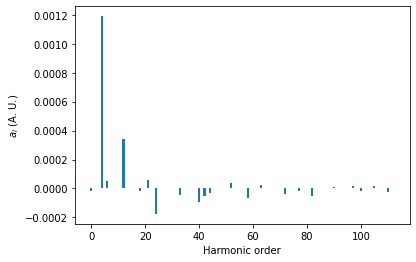

vp recons =  1.0252483607718241
vp pert =  1.0252485606149448
vp ref =  1.0252767233369111
sens -2.679195232008307
sens recons -2.6982073697090976
delta recons -0.019012137700790518


/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


pert/ref - 1 (mean, std, min, max, relative entropy) :  -0.40495188032064033 0.6109483532439572 -1.892960226874634 0.2014618730652216 1.4852828151133356e-06 1
recons/pert - 1 (mean, std, min, max, relative entropy) :  0.311338792405888 0.5061023218923129 -0.015973478116695392 1.6481709907322628 3.009651185543486e-07 0.20263152275910715
power pert/ref - 1 (mean, std, min, max, relative entropy) :  -0.019164827355812573 0.13746653889131957 -0.3692051899689503 0.2013202261087215 8.543841124886514e-07 1
power recons/pert - 1 (mean, std, min, max, relative entropy) :  -5.434696346122514e-05 0.015465010780362817 -0.15205488719513907 0.08137099353199241 6.3781566106497845e-09 0.007465209754511329


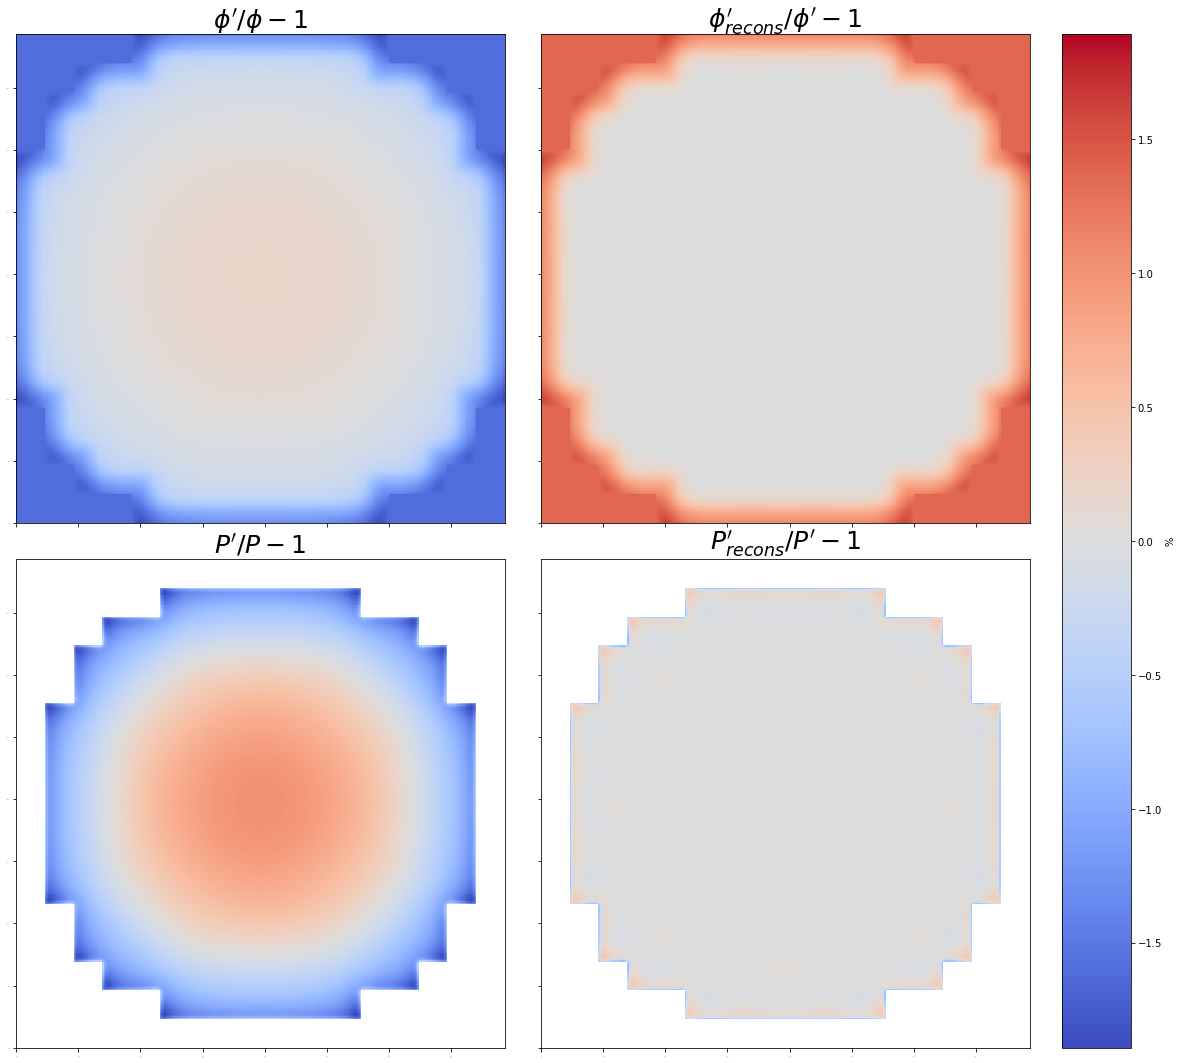

time: 34.6 s (started: 2022-11-24 09:09:28 +01:00)


In [28]:
set_log_level(log_level.debug)
_, _, a = pert.firstOrderPerturbation(
    s, s_star, s_recons_refl2, "PhiStarMPhi")

plot_recons_coeff(a)
(delta_refl, delta_recons_refl, re_refl,
            delta_power_refl, delta_recons_power_refl, re_power_refl) = plot_delta(s, s_recons_refl2, s_pert_refl2)

## Modification of only one fuel assembly 

In [29]:
fuel6 = [[1.4389, 0.010165, 0.0061908, 1, 0., 0.017125, 202 * 1.60218e-19 * 1e6, 2.4],
         [0.3679, 0.088024, 0.1035800*1.01, 0, 0., 0., 202 * 1.60218e-19 * 1e6, 2.4]]
mat_lib.addMaterial(fuel6, "fuel6_pert", reac_names)

x = [0, 17 * 23.1226]
y = [0, 17 * 23.1226]


pblm = np.array([["void",  "void",  "void",  "void",  "refl",  "refl",  "refl",  "refl",  "refl",  "refl",  "refl",  "refl",  "refl",  "void",  "void",  "void",  "void"], 
                 ["void",  "void",  "refl",  "refl",  "refl",  "fuel3", "fuel3", "fuel3", "fuel3", "fuel3", "fuel3", "fuel3", "refl",  "refl",  "refl",  "void",  "void"], 
                 ["void",  "refl",  "refl",  "fuel3", "fuel3", "fuel7", "fuel1", "fuel1", "fuel1", "fuel1", "fuel1", "fuel7", "fuel3", "fuel3", "refl",  "refl",  "void"], 
                 ["void",  "refl",  "fuel3", "fuel3", "fuel4", "fuel1", "fuel6", "fuel1", "fuel6", "fuel1", "fuel6", "fuel1", "fuel4", "fuel3", "fuel3", "refl",  "void"], 
                 ["refl",  "refl",  "fuel3", "fuel4", "fuel2", "fuel7", "fuel2", "fuel7", "fuel1", "fuel7", "fuel2", "fuel7", "fuel2", "fuel4", "fuel3", "refl",  "refl"],  
                 ["refl",  "fuel3", "fuel7", "fuel1", "fuel7", "fuel2", "fuel7", "fuel2", "fuel5", "fuel2", "fuel7", "fuel2", "fuel7", "fuel1", "fuel7", "fuel3", "refl"],  
                 ["refl",  "fuel3", "fuel1", "fuel6", "fuel2", "fuel7", "fuel1", "fuel7", "fuel2", "fuel7", "fuel1", "fuel7", "fuel2", "fuel6", "fuel1", "fuel3", "refl"],  
                 ["refl",  "fuel3", "fuel1", "fuel1", "fuel7", "fuel2", "fuel7", "fuel1", "fuel7", "fuel1", "fuel7", "fuel2", "fuel7", "fuel1", "fuel1", "fuel3", "refl"],  
                 ["refl",  "fuel3", "fuel1", "fuel6", "fuel1", "fuel5", "fuel2", "fuel7", "fuel1", "fuel7", "fuel2", "fuel5", "fuel1", "fuel6", "fuel1", "fuel3", "refl"],  
                 ["refl",  "fuel3", "fuel1", "fuel1", "fuel7", "fuel2", "fuel7", "fuel1", "fuel7", "fuel1", "fuel7", "fuel2", "fuel7", "fuel1", "fuel1", "fuel3", "refl"],  
                 ["refl",  "fuel3", "fuel1", "fuel6", "fuel2", "fuel7", "fuel1", "fuel7", "fuel2", "fuel7", "fuel1", "fuel7", "fuel2", "fuel6", "fuel1", "fuel3", "refl"],  
                 ["refl",  "fuel3", "fuel7", "fuel1", "fuel7", "fuel2", "fuel7", "fuel2", "fuel5", "fuel2", "fuel7", "fuel2", "fuel7", "fuel1", "fuel7", "fuel3", "refl"],  
                 ["refl",  "refl",  "fuel3", "fuel4", "fuel2", "fuel7", "fuel2", "fuel7", "fuel1", "fuel7", "fuel2", "fuel7", "fuel2", "fuel4", "fuel3", "refl",  "refl"],  
                 ["void",  "refl",  "fuel3", "fuel3", "fuel4", "fuel1", "fuel6_pert", "fuel1", "fuel6", "fuel1", "fuel6", "fuel1", "fuel4", "fuel3", "fuel3", "refl",  "void"], 
                 ["void",  "refl",  "refl",  "fuel3", "fuel3", "fuel7", "fuel1", "fuel1", "fuel1", "fuel1", "fuel1", "fuel7", "fuel3", "fuel3", "refl",  "refl",  "void"], 
                 ["void",  "void",  "refl",  "refl",  "refl",  "fuel3", "fuel3", "fuel3", "fuel3", "fuel3", "fuel3", "fuel3", "refl",  "refl",  "refl",  "void",  "void"], 
                 ["void",  "void",  "void",  "void",  "refl",  "refl",  "refl",  "refl",  "refl",  "refl",  "refl",  "refl",  "refl",  "void",  "void",  "void",  "void"]])
# print(pblm)

#we mesh it 
nb_div_pmat_x = 20
nb_div_pmat_y = 20
shape = (pblm.shape[0]*nb_div_pmat_y, pblm.shape[1]*nb_div_pmat_x)
geom = np.empty(shape, dtype='U16')
for i, row in enumerate(pblm):
    for j, value in enumerate(row):
        geom[i*nb_div_pmat_x:(i+1)*nb_div_pmat_x, j *
             nb_div_pmat_x:(j+1)*nb_div_pmat_x] = value

geometry = np.array([geom])

x_mesh = np.linspace(x[0], x[1], geom.shape[1]+1)
x_mean = (x_mesh[:-1] + x_mesh[1:])/2.
dx = x_mesh[1:]-x_mesh[:-1]
y_mesh = np.linspace(y[0], y[1], geom.shape[0]+1)
y_mean = (y_mesh[:-1] + y_mesh[1:])/2.
dy = y_mesh[1:]-y_mesh[:-1]

macrolib_pert = mat.Macrolib(mat_lib, geometry)

s_pert_fuel = solver.SolverFullSlepc(x_mesh, y_mesh,
                                macrolib_pert, 0., 0., 0., 0.)
s_pert_fuel.solve(tol=1e-15, nb_eigen_values=1, inner_max_iter=10, tol_inner=1e-3)

s_recons_fuel = solver.SolverFullSlepc(s_pert_fuel)

[2022-11-24 09:10:19.759] [debug] Solver : krylovschur
[2022-11-24 09:10:19.759] [debug] Inner solver : 
[2022-11-24 09:10:19.759] [debug] Inner precond : 
[2022-11-24 09:10:19.759] [debug] Tolerance in outter iteration (eigen value): 1.00e-15
[2022-11-24 09:10:19.759] [debug] Tolerance in inner iteration : 1.00e-03
[2022-11-24 09:10:19.759] [debug] Max. outer iteration : 500
[2022-11-24 09:10:19.759] [debug] Max. inner iteration : 10
[2022-11-24 09:10:28.178] [info] Number of converged eigenpairs: 1
[2022-11-24 09:10:28.178] [debug] Number of outter iteration: 12
[2022-11-24 09:10:28.178] [debug] Slepc converged reason: tolerance
[2022-11-24 09:10:28.206] [info] Eigen value 0 = 1.02531 +- 1.20e-06
time: 13.5 s (started: 2022-11-24 09:10:14 +01:00)


vp recons =  1.0253126130255477
vp pert =  1.0253137561061274
vp ref =  1.0252767233369111
sens 3.522802588643566
sens recons 3.414068989828138
delta recons -0.10873359881542768


/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


pert/ref - 1 (mean, std, min, max, relative entropy) :  0.0009512402267698764 0.9434600044774892 -0.9647320379905031 3.542844508211777 4.0034483243339824e-05 1
recons/pert - 1 (mean, std, min, max, relative entropy) :  0.0067288129962151475 0.7981061002688928 -1.6609827539417148 1.3796148242012565 2.8083173251773424e-05 0.7014746033082709
power pert/ref - 1 (mean, std, min, max, relative entropy) :  0.005657015472189789 0.9344615365917238 -0.9645827128468433 4.30157824438148 4.119601879668508e-05 1
power recons/pert - 1 (mean, std, min, max, relative entropy) :  0.005736367310939605 0.7653422471677114 -1.6417817582650047 1.3752328359597346 2.8006172323578573e-05 0.6798271566434023


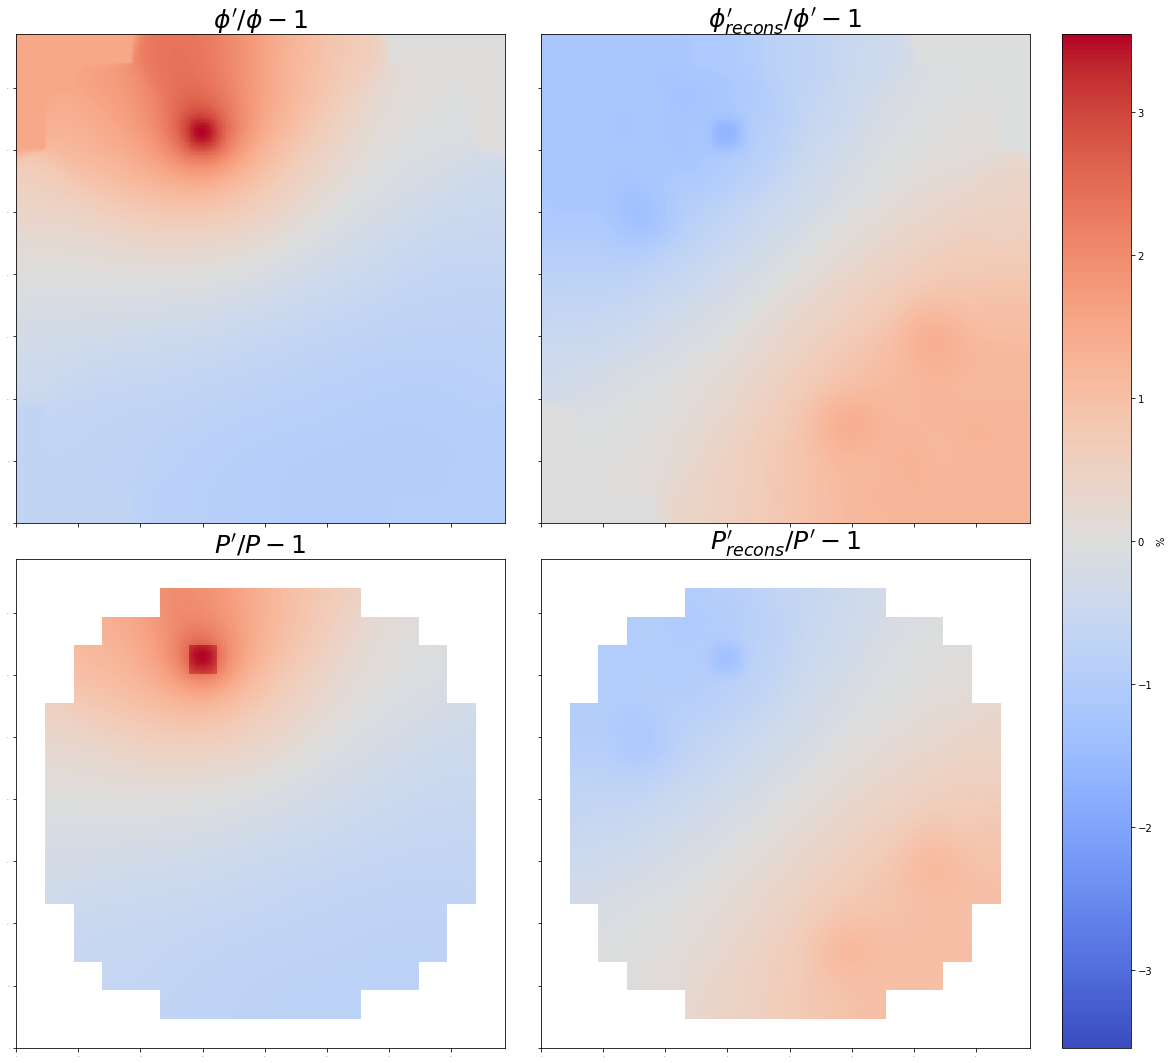

time: 32.3 s (started: 2022-11-24 09:10:29 +01:00)


In [30]:
_, _, a = pert.firstOrderPerturbation(
    s, s_star, s_recons_fuel, "PhiStarMPhi")

(delta_sigf_ass, delta_recons_sigf_ass, re_sigf_ass,
            delta_power_sigf_ass, delta_recons_power_sigf_ass, re_power_sigf_ass) = plot_delta(s, s_recons_fuel, s_pert_fuel)

In [31]:
# _, _, _ = pert.highOrderPerturbation(2, 
#     s, s_star, s_recons_fuel)

# plot_delta(s, s_recons_fuel, s_pert_fuel)

time: 871 µs (started: 2022-11-24 09:11:05 +01:00)


[2022-11-24 09:11:22.247] [debug] Solver : krylovschur
[2022-11-24 09:11:22.247] [debug] Inner solver : 
[2022-11-24 09:11:22.247] [debug] Inner precond : 
[2022-11-24 09:11:22.247] [debug] Tolerance in outter iteration (eigen value): 1.00e-15
[2022-11-24 09:11:22.247] [debug] Tolerance in inner iteration : 1.00e-03
[2022-11-24 09:11:22.247] [debug] Max. outer iteration : 500
[2022-11-24 09:11:22.247] [debug] Max. inner iteration : 10
[2022-11-24 09:11:29.973] [info] Number of converged eigenpairs: 1
[2022-11-24 09:11:29.973] [debug] Number of outter iteration: 12
[2022-11-24 09:11:29.973] [debug] Slepc converged reason: tolerance
[2022-11-24 09:11:29.982] [info] Eigen value 0 = 1.02522 +- 1.20e-06
vp recons =  1.02522220297894
vp pert =  1.0252249248852867
vp ref =  1.0252767233369111
sens -4.92783915566994
sens recons -5.186801142948866
delta recons -0.2589619872789263


/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


pert/ref - 1 (mean, std, min, max, relative entropy) :  -0.0037493926855066925 1.3358226645761115 -5.078484205898949 1.3685407581432085 8.176320536385758e-05 1
recons/pert - 1 (mean, std, min, max, relative entropy) :  0.008996472208658894 1.1381015008992912 -2.0561947846308986 2.1481658742760037 5.681586835368527e-05 0.6948830846448204
power pert/ref - 1 (mean, std, min, max, relative entropy) :  -0.007728897506225694 1.3113552203309875 -5.597663434715241 1.3683269235531221 8.279943117420037e-05 1
power recons/pert - 1 (mean, std, min, max, relative entropy) :  0.011597645978447783 1.097423426548892 -2.0474710689151774 2.700704162081335 5.721230309269754e-05 0.6909745910250218


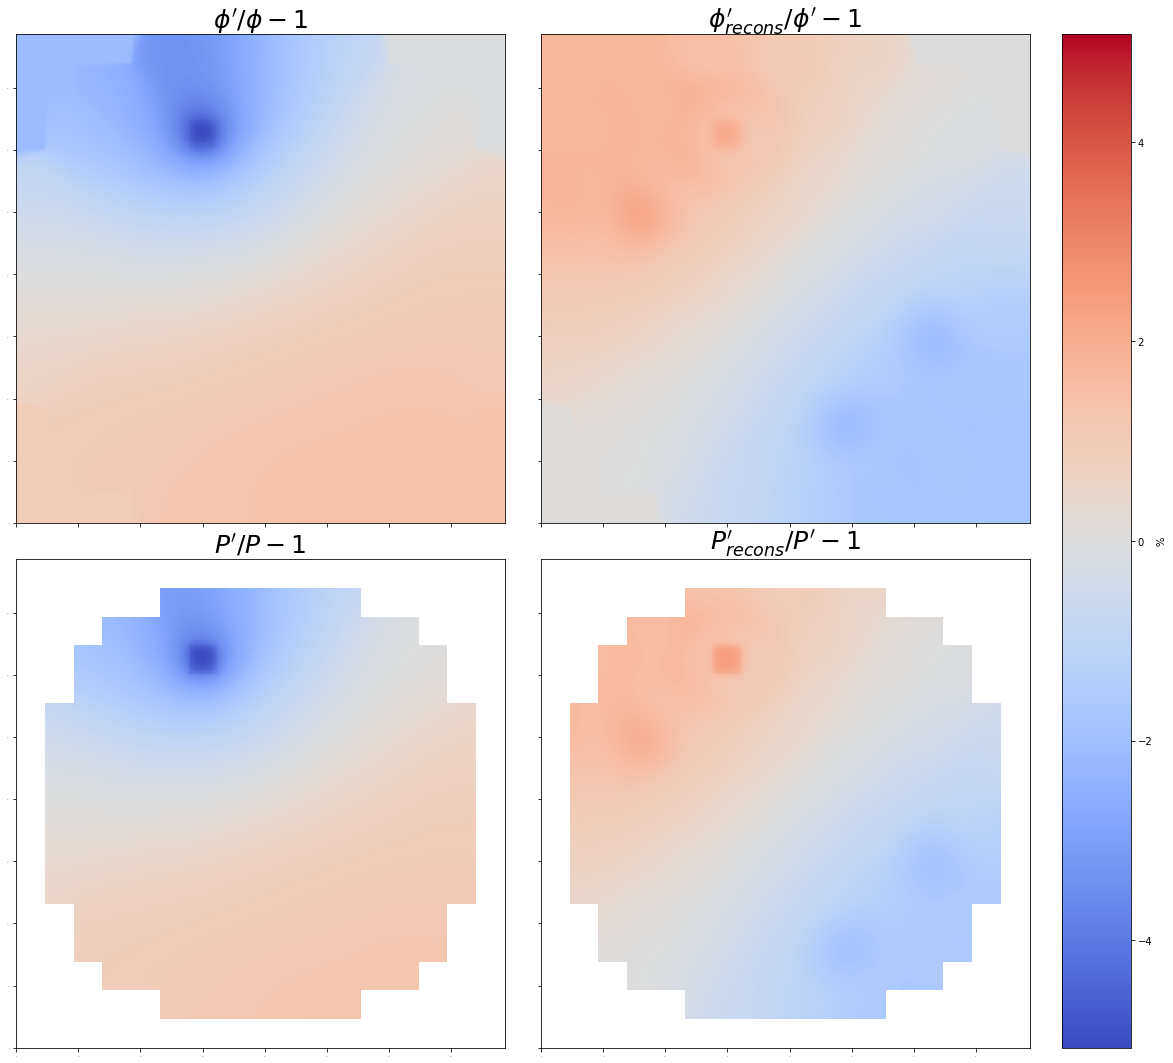

time: 46.4 s (started: 2022-11-24 09:11:17 +01:00)


In [32]:
fuel6 = [[1.4389, 0.010165*1.01, 0.0061908, 1, 0., 0.017125, 202 * 1.60218e-19 * 1e6, 2.4],
         [0.3679, 0.088024*1.01, 0.1035800, 0, 0., 0., 202 * 1.60218e-19 * 1e6, 2.4]]
mat_lib.addMaterial(fuel6, "fuel6_pert_sigr", reac_names)

x = [0, 17 * 23.1226]
y = [0, 17 * 23.1226]


pblm = np.array([["void",  "void",  "void",  "void",  "refl",  "refl",  "refl",  "refl",  "refl",  "refl",  "refl",  "refl",  "refl",  "void",  "void",  "void",  "void"], 
                 ["void",  "void",  "refl",  "refl",  "refl",  "fuel3", "fuel3", "fuel3", "fuel3", "fuel3", "fuel3", "fuel3", "refl",  "refl",  "refl",  "void",  "void"], 
                 ["void",  "refl",  "refl",  "fuel3", "fuel3", "fuel7", "fuel1", "fuel1", "fuel1", "fuel1", "fuel1", "fuel7", "fuel3", "fuel3", "refl",  "refl",  "void"], 
                 ["void",  "refl",  "fuel3", "fuel3", "fuel4", "fuel1", "fuel6", "fuel1", "fuel6", "fuel1", "fuel6", "fuel1", "fuel4", "fuel3", "fuel3", "refl",  "void"], 
                 ["refl",  "refl",  "fuel3", "fuel4", "fuel2", "fuel7", "fuel2", "fuel7", "fuel1", "fuel7", "fuel2", "fuel7", "fuel2", "fuel4", "fuel3", "refl",  "refl"],  
                 ["refl",  "fuel3", "fuel7", "fuel1", "fuel7", "fuel2", "fuel7", "fuel2", "fuel5", "fuel2", "fuel7", "fuel2", "fuel7", "fuel1", "fuel7", "fuel3", "refl"],  
                 ["refl",  "fuel3", "fuel1", "fuel6", "fuel2", "fuel7", "fuel1", "fuel7", "fuel2", "fuel7", "fuel1", "fuel7", "fuel2", "fuel6", "fuel1", "fuel3", "refl"],  
                 ["refl",  "fuel3", "fuel1", "fuel1", "fuel7", "fuel2", "fuel7", "fuel1", "fuel7", "fuel1", "fuel7", "fuel2", "fuel7", "fuel1", "fuel1", "fuel3", "refl"],  
                 ["refl",  "fuel3", "fuel1", "fuel6", "fuel1", "fuel5", "fuel2", "fuel7", "fuel1", "fuel7", "fuel2", "fuel5", "fuel1", "fuel6", "fuel1", "fuel3", "refl"],  
                 ["refl",  "fuel3", "fuel1", "fuel1", "fuel7", "fuel2", "fuel7", "fuel1", "fuel7", "fuel1", "fuel7", "fuel2", "fuel7", "fuel1", "fuel1", "fuel3", "refl"],  
                 ["refl",  "fuel3", "fuel1", "fuel6", "fuel2", "fuel7", "fuel1", "fuel7", "fuel2", "fuel7", "fuel1", "fuel7", "fuel2", "fuel6", "fuel1", "fuel3", "refl"],  
                 ["refl",  "fuel3", "fuel7", "fuel1", "fuel7", "fuel2", "fuel7", "fuel2", "fuel5", "fuel2", "fuel7", "fuel2", "fuel7", "fuel1", "fuel7", "fuel3", "refl"],  
                 ["refl",  "refl",  "fuel3", "fuel4", "fuel2", "fuel7", "fuel2", "fuel7", "fuel1", "fuel7", "fuel2", "fuel7", "fuel2", "fuel4", "fuel3", "refl",  "refl"],  
                 ["void",  "refl",  "fuel3", "fuel3", "fuel4", "fuel1", "fuel6_pert_sigr", "fuel1", "fuel6", "fuel1", "fuel6", "fuel1", "fuel4", "fuel3", "fuel3", "refl",  "void"], 
                 ["void",  "refl",  "refl",  "fuel3", "fuel3", "fuel7", "fuel1", "fuel1", "fuel1", "fuel1", "fuel1", "fuel7", "fuel3", "fuel3", "refl",  "refl",  "void"], 
                 ["void",  "void",  "refl",  "refl",  "refl",  "fuel3", "fuel3", "fuel3", "fuel3", "fuel3", "fuel3", "fuel3", "refl",  "refl",  "refl",  "void",  "void"], 
                 ["void",  "void",  "void",  "void",  "refl",  "refl",  "refl",  "refl",  "refl",  "refl",  "refl",  "refl",  "refl",  "void",  "void",  "void",  "void"]])
# print(pblm)

#we mesh it 
nb_div_pmat_x = 20
nb_div_pmat_y = 20
shape = (pblm.shape[0]*nb_div_pmat_y, pblm.shape[1]*nb_div_pmat_x)
geom = np.empty(shape, dtype='U16')
for i, row in enumerate(pblm):
    for j, value in enumerate(row):
        geom[i*nb_div_pmat_x:(i+1)*nb_div_pmat_x, j *
             nb_div_pmat_x:(j+1)*nb_div_pmat_x] = value

geometry = np.array([geom])

x_mesh = np.linspace(x[0], x[1], geom.shape[1]+1)
x_mean = (x_mesh[:-1] + x_mesh[1:])/2.
dx = x_mesh[1:]-x_mesh[:-1]
y_mesh = np.linspace(y[0], y[1], geom.shape[0]+1)
y_mean = (y_mesh[:-1] + y_mesh[1:])/2.
dy = y_mesh[1:]-y_mesh[:-1]

macrolib_pert = mat.Macrolib(mat_lib, geometry)

s_pert_fuel_sigr = solver.SolverFullSlepc(x_mesh, y_mesh,
                                macrolib_pert, 0., 0., 0., 0.)
s_pert_fuel_sigr.solve(tol=1e-15, nb_eigen_values=1, inner_max_iter=10, tol_inner=1e-3)

s_recons_fuel_sigr = solver.SolverFullSlepc(s_pert_fuel_sigr)

_, _, a = pert.firstOrderPerturbation(
    s, s_star, s_recons_fuel_sigr, "PhiStarMPhi")

(delta_sigr_ass, delta_recons_sigr_ass, re_sigr_ass,
            delta_power_sigr_ass, delta_recons_power_sigr_ass, re_power_sigr_ass) = plot_delta(s, s_recons_fuel_sigr, s_pert_fuel_sigr)

$\phi$ & 0.010 & 0.701 & 0.010 & 0.695 & 0.203 \\ \hline
Power & 0.007 & 0.680 & 0.009 & 0.691 & 0.007 \\ \hline


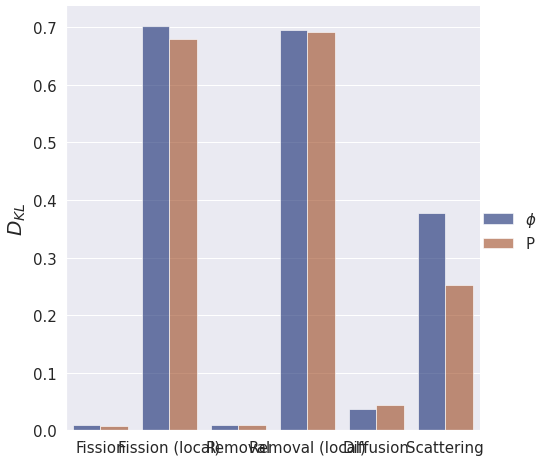

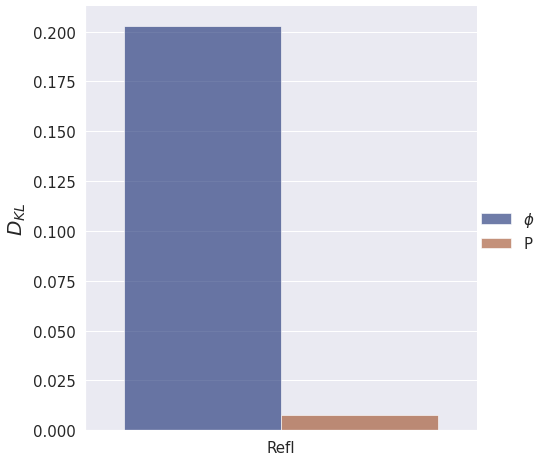

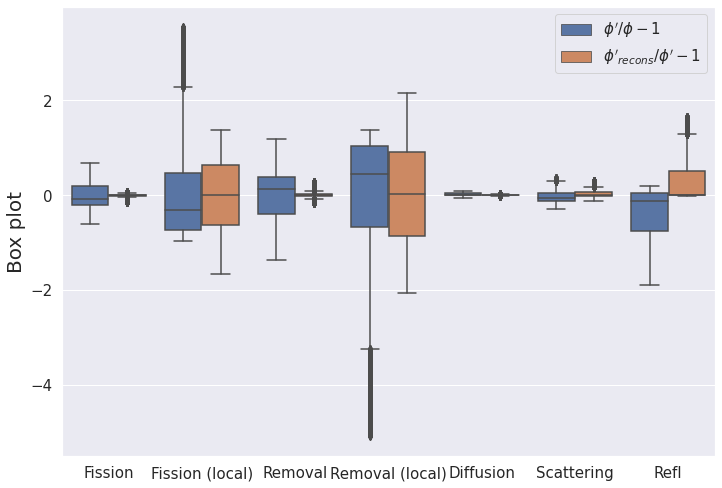

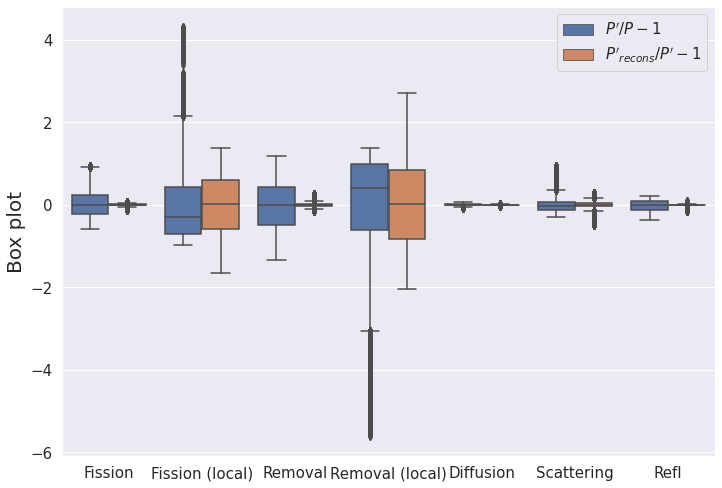

time: 17.3 s (started: 2022-11-24 09:12:14 +01:00)


In [33]:
print(f"$\phi$ & {re_sigf:.3f} & {re_sigf_ass:.3f} & {re_sigr:.3f} & {re_sigr_ass:.3f} & {re_refl:.3f} \\\ \hline")
print(f"Power & {re_power_sigf:.3f} & {re_power_sigf_ass:.3f} & {re_power_sigr:.3f} & {re_power_sigr_ass:.3f} & {re_power_refl:.3f} \\\ \hline")


SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

sns.set(rc={'figure.figsize':(11.7, 8.27),
             "font.size": SMALL_SIZE, "axes.titlesize": SMALL_SIZE, "axes.labelsize": MEDIUM_SIZE,
             "xtick.labelsize": SMALL_SIZE, "ytick.labelsize": SMALL_SIZE,
             "legend.fontsize": SMALL_SIZE, "figure.titlesize": BIGGER_SIZE})

iterables = [["Fission", "Fission (local)", "Removal", "Removal (local)", "Diffusion", "Scattering"], ["$\phi$", "P"]]
index = pd.MultiIndex.from_product(iterables, names=["first", "second"])
D_kl = pd.DataFrame([re_sigf, re_power_sigf,
                     re_sigf_ass, re_power_sigf_ass,
                     re_sigr, re_power_sigr,
                     re_sigr_ass, re_power_sigr_ass,
                     re_D, re_power_D,
                     re_scatt, re_power_scatt],
                     index=index)
D_kl = D_kl.unstack([0, 1]).to_frame().reset_index([-1, -2])
D_kl.columns = ["Case", "", "$D_{KL}$"]
# print(D_kl)
ax = sns.catplot(
    data=D_kl, kind="bar",
    x="Case", y="$D_{KL}$", hue="",
    errorbar="sd", palette="dark", alpha=.6, height=7
)
ax.set(xlabel=None)
plt.show()


iterables = [["Refl"], ["$\phi$", "P"]]
index = pd.MultiIndex.from_product(iterables, names=["first", "second"])
D_kl = pd.DataFrame([re_refl, re_power_refl],
                     index=index)
D_kl = D_kl.unstack([0, 1]).to_frame().reset_index([-1, -2])
D_kl.columns = ["Case", "", "$D_{KL}$"]
# print(D_kl)
ax = sns.catplot(
    data=D_kl, kind="bar",
    x="Case", y="$D_{KL}$", hue="",
    errorbar="sd", palette="dark", alpha=.6, height=7
)
ax.set(xlabel=None)
plt.show()
ax.set(xlabel=None)
plt.show()
             
iterables = [["Fission", "Fission (local)", "Removal", "Removal (local)", "Diffusion", "Scattering", "Refl"], ["$\phi'/\phi -1$", "$\phi'_{recons}/\phi' -1$"]]
index = pd.MultiIndex.from_product(iterables, names=["first", "second"])

data = pd.DataFrame([delta_sigf.flatten()/3., delta_recons_sigf.flatten()/3.,
                     delta_sigf_ass.flatten(), delta_recons_sigf_ass.flatten(),
                     delta_sigr.flatten()/2., delta_recons_sigr.flatten()/2.,
                     delta_sigr_ass.flatten(), delta_recons_sigr_ass.flatten(),
                     delta_D.flatten(), delta_recons_D.flatten(),
                     delta_scatt.flatten(), delta_recons_scatt.flatten(),
                     delta_refl.flatten(), delta_recons_refl.flatten()],
                     index=index)
data = data.unstack([0, 1]).to_frame().reset_index([-1, -2])
data.columns = ["Case", "", "Box plot"]

iterables = [["Fission", "Fission (local)", "Removal", "Removal (local)", "Diffusion", "Scattering", "Refl"], ["$P'/P -1$", "$P'_{recons}/P' -1$"]]
index = pd.MultiIndex.from_product(iterables, names=["first", "second"])
data_power = pd.DataFrame([delta_power_sigf.flatten()/3., delta_recons_power_sigf.flatten()/3.,
                           delta_power_sigf_ass.flatten(), delta_recons_power_sigf_ass.flatten(),
                           delta_power_sigr.flatten()/2., delta_recons_power_sigr.flatten()/2.,
                           delta_power_sigr_ass.flatten(), delta_recons_power_sigr_ass.flatten(),
                           delta_power_D.flatten(), delta_recons_power_D.flatten(),
                           delta_power_scatt.flatten(), delta_recons_power_scatt.flatten(),
                           delta_power_refl.flatten(), delta_recons_power_refl.flatten()],
                           index=index)
data_power = data_power.unstack([0, 1]).to_frame().reset_index([-1, -2])
data_power.columns = ["Case", "", "Box plot"]


ax = sns.boxplot(data=data, x="Case", y="Box plot", hue="")
ax.set(xlabel=None)
plt.show()

ax = sns.boxplot(data=data_power, x="Case", y="Box plot", hue="")
ax.set(xlabel=None)
plt.show()

